In [38]:
# ENV_NAME = "MiniGrid-Empty-16x16-v0"
# OFFLINE_DATASET_VERSION = 5
# FULLY_OBSERVABLE_EXPERT_ENV = False

# ENV_NAME = "MiniGrid-LavaGapS5-v0"
# OFFLINE_DATASET_VERSION = 0
# FULLY_OBSERVABLE_EXPERT_ENV = False

ENV_NAME = "MiniGrid-SimpleCrossingS9N1-v0"
OFFLINE_DATASET_VERSION = 0
FULLY_OBSERVABLE_EXPERT_ENV = True

# ENV_NAME = "MiniGrid-LavaCrossingS9N1-v0"
# OFFLINE_DATASET_VERSION = 0
# FULLY_OBSERVABLE_EXPERT_ENV = False

In [ ]:
EVAL_MASTER_SEED = 42

def make_eval_seeds(n_eval_envs, master_seed=EVAL_MASTER_SEED):
    import random
    rng = random.Random(int(master_seed))
    return [rng.randrange(0, 2**31 - 1) for _ in range(int(n_eval_envs))]


## Train expert policy w/ online RL

In [ ]:
import os
import sys

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from gymnasium import spaces
from rl_zoo3.train import train
from stable_baselines3 import PPO
from torch.utils.data import DataLoader
from tqdm import tqdm

import minari
from minari import DataCollector

torch.manual_seed(42)

In [40]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 512,
                 normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            obs_tensor = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(obs_tensor).shape[1]
        
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(x))

In [41]:
# # TRAIN EXPERT POLICY (vectorized envs)

# import os
# import gymnasium as gym
# import minigrid
# from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper

# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
# from stable_baselines3.common.utils import set_random_seed

# CONTINUE_FROM_PRETRAINED = True
# PRETRAINED_PATH = None  # e.g. f"./logs/ppo/{ENV_NAME}/best_model_full_obs" (or leave None to use default)

# policy_kwargs = dict(
#     features_extractor_class=MinigridFeaturesExtractor,
#     features_extractor_kwargs=dict(features_dim=128),
# )

# N_ENVS = 2
# GLOBAL_SEED = 0
# TOTAL_TIMESTEPS = 2e5 # 8e5

# def make_env(rank: int):
#     def _init():
#         env = gym.make(ENV_NAME)
#         if FULLY_OBSERVABLE_EXPERT_ENV:
#             env = FullyObsWrapper(env)
#         env = ImgObsWrapper(env)
#         return env
#     return _init

# best_ckpt_name = "best_model_full_obs" if FULLY_OBSERVABLE_EXPERT_ENV else "best_model"
# default_ckpt_path = f"./logs/ppo/{ENV_NAME}/{best_ckpt_name}"
# ckpt_path = PRETRAINED_PATH or default_ckpt_path

# set_random_seed(GLOBAL_SEED)
# env = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])
# env = VecMonitor(env)

# if CONTINUE_FROM_PRETRAINED and os.path.exists(ckpt_path + ".zip"):
#     model = PPO.load(ckpt_path, env=env, device="auto")
# else:
#     model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1, seed=GLOBAL_SEED, device="auto")

# model.learn(total_timesteps=int(TOTAL_TIMESTEPS * N_ENVS))
# model.save(default_ckpt_path)

# env.close()

In [ ]:
# EVAL EXPERT POLICY
from tqdm import tqdm
import minigrid
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper

N_EVAL_ENVS = 100
eval_seeds = make_eval_seeds(N_EVAL_ENVS)

# Load expert model
if FULLY_OBSERVABLE_EXPERT_ENV:
    best_ckpt_name = "best_model_full_obs"
else:
    best_ckpt_name = "best_model"

model = PPO.load(f"./logs/ppo/{ENV_NAME}/{best_ckpt_name}")

eval_env = gym.make(ENV_NAME)
if FULLY_OBSERVABLE_EXPERT_ENV:
    eval_env = FullyObsWrapper(eval_env)
eval_env = ImgObsWrapper(eval_env)

scores = []
for seed in tqdm(eval_seeds):
    obs, _ = eval_env.reset(seed=seed)
    terminated, truncated = False, False
    accumulated_rew = 0
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = eval_env.step(action)
        accumulated_rew += reward
    scores.append(accumulated_rew)
mean_score = sum(scores) / len(scores)
print(f"Expert PPO eval: mean reward@{N_EVAL_ENVS} = {mean_score:.2f}")

100%|██████████| 100/100 [00:04<00:00, 22.86it/s]

Expert PPO eval: mean reward@100 = 0.74


In [30]:
import gymnasium as gym
from gymnasium.utils import RecordConstructorArgs
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper


class RecordedImgObsWrapper(ImgObsWrapper, RecordConstructorArgs):
    def __init__(self, env, partial_obs=True):
        RecordConstructorArgs.__init__(self)
        super().__init__(env)


def make_bc_env(env_name, fully_observed=False, render_mode=None):
    env = gym.make(env_name, render_mode=render_mode) if render_mode else gym.make(env_name)
    if fully_observed:
        env = FullyObsWrapper(env)
    return RecordedImgObsWrapper(env)


In [31]:
# base_env = gym.make(ENV_NAME)
# if FULLY_OBSERVABLE_EXPERT_ENV:
#     base_env = FullyObsWrapper(base_env)
# base_env = RecordedImgObsWrapper(base_env)

# env = DataCollector(base_env, data_format="parquet")
# best_ckpt_name = "best_model_full_obs" if FULLY_OBSERVABLE_EXPERT_ENV else "best_model"
# path = f"./logs/ppo/{ENV_NAME}/{best_ckpt_name}"
# agent = PPO.load(path)

# total_episodes = 1_000

# for _ in tqdm(range(total_episodes)):
#     obs, _ = env.reset()
#     terminated = False
#     truncated = False
#     while not (terminated or truncated):
#         action, _ = agent.predict(obs, deterministic=True)
#         obs, rew, terminated, truncated, info = env.step(action)

In [32]:
# dataset_name = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
# dataset = env.create_dataset(
#     dataset_id=dataset_name,
#     algorithm_name="ExpertPolicy",
#     code_permalink="https://minari.farama.org/tutorials/behavioral_cloning",
#     author="Farama",
#     author_email="contact@farama.org",
# )

# print(f"Collected dataset:\n{dataset_name}")

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNPolicyNetwork(nn.Module):
    def __init__(self, observation_space, output_dim):
        super().__init__()

        obs_shape = observation_space.shape
        input_channels = obs_shape[2] if len(obs_shape) == 3 else 1

        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            sample_obs = observation_space.sample()
            sample_obs = torch.from_numpy(sample_obs).permute(2, 0, 1).unsqueeze(0).float() if len(obs_shape) == 3 else torch.from_numpy(sample_obs).unsqueeze(0).unsqueeze(0).float()
            n_flatten = self.cnn(sample_obs).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU()
        )
        self.head = nn.Linear(512, output_dim)

    def forward(self, x):
        # Expect either (B,H,W,C) or (H,W,C)
        if x.dim() == 3:
            x = x.permute(2, 0, 1).unsqueeze(0)
        elif x.dim() == 4:
            x = x.permute(0, 3, 1, 2)
        else:
            raise NotImplementedError(f"Expected 3 or 4 dimensions, got {x.dim()}")
        features = self.linear(self.cnn(x.float()))
        logits = self.head(features)
        return logits

In [34]:
def collate_fn(batch):
    """Create episode-major padded batches with mask.

    Returns tensors with shape [B, T, ...] and a boolean mask [B, T]
    indicating valid (non-padded) time steps.
    """
    obs_list = []
    actions_list = []
    rewards_list = []
    terminations_list = []
    truncations_list = []
    lengths = []

    for ep in batch:
        frames = np.asarray(ep.observations, dtype=np.float32)
        if frames.ndim == 3:
            frames = frames[None, ...]

        T = len(ep.actions)
        frames = frames[:T]
        obs_list.append(torch.from_numpy(frames))
        actions_list.append(torch.as_tensor(ep.actions))
        rewards_list.append(torch.as_tensor(ep.rewards))
        terminations_list.append(torch.as_tensor(ep.terminations))
        truncations_list.append(torch.as_tensor(ep.truncations))
        lengths.append(T)

    B = len(batch)
    max_T = max(lengths)

    obs0 = obs_list[0]
    obs_shape = obs0.shape[1:]

    observations = torch.zeros((B, max_T) + obs_shape, dtype=torch.float32)
    actions = torch.full((B, max_T), -1, dtype=torch.long)
    rewards = torch.zeros((B, max_T), dtype=torch.float32)
    terminations = torch.zeros((B, max_T), dtype=torch.bool)
    truncations = torch.zeros((B, max_T), dtype=torch.bool)
    mask = torch.zeros((B, max_T), dtype=torch.bool)
    ids = torch.empty((B, max_T), dtype=torch.long)

    for i, (obs_i, act_i, rew_i, term_i, trunc_i, T_i) in enumerate(
        zip(obs_list, actions_list, rewards_list, terminations_list, truncations_list, lengths)
    ):
        observations[i, :T_i] = obs_i
        actions[i, :T_i] = act_i
        rewards[i, :T_i] = rew_i
        terminations[i, :T_i] = term_i
        truncations[i, :T_i] = trunc_i
        mask[i, :T_i] = True
        ids[i, :T_i] = batch[i].id

    lengths_tensor = torch.as_tensor(lengths, dtype=torch.long)

    return {
        "id": ids,
        "observations": observations,
        "actions": actions,
        "rewards": rewards,
        "terminations": terminations,
        "truncations": truncations,
        "mask": mask,
        "lengths": lengths_tensor,
    }

In [ ]:
# Train BC

DATASET_NAME = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
NUM_EPOCHS = 12
EVAL_EVERY_N_EPOCHS = 2
N_EVAL_ENVS = 100
eval_seeds = make_eval_seeds(N_EVAL_ENVS)

minari_dataset = minari.load_dataset(DATASET_NAME)
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

def make_bc_env(env_name, fully_observed=False, render_mode=None):
    env = gym.make(env_name, render_mode=render_mode) if render_mode else gym.make(env_name)
    if fully_observed:
        env = FullyObsWrapper(env)
    return RecordedImgObsWrapper(env)

env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV)
eval_env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV, render_mode="rgb_array")

observation_space = env.observation_space
action_space = env.action_space
assert isinstance(observation_space, spaces.Box)
assert isinstance(action_space, spaces.Discrete)

net_policy = CNNPolicyNetwork(observation_space, action_space.n)
optimizer_policy = torch.optim.Adam(net_policy.parameters())
loss_fn = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        obs = batch["observations"]
        actions = batch["actions"]
        mask = batch["mask"]

        B, T = actions.shape[:2]
        obs = obs.reshape(B * T, *obs.shape[2:])
        actions = actions.reshape(B * T)
        mask_flat = mask.reshape(B * T)

        obs = obs[mask_flat]
        actions = actions[mask_flat].long()

        a_pred = net_policy(obs)
        loss = loss_fn(a_pred, actions)

        optimizer_policy.zero_grad()
        loss.backward()
        optimizer_policy.step()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item():.3f}")

    if (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0:
        scores = []
        for seed in eval_seeds:
            obs, _ = eval_env.reset(seed=seed)
            terminated, truncated = False, False
            accumulated_rew = 0
            while not (terminated or truncated):
                with torch.no_grad():
                    action = net_policy(torch.Tensor(obs)).argmax().item()
                obs, reward, terminated, truncated, _ = eval_env.step(action)
                accumulated_rew += reward
            scores.append(accumulated_rew)
        mean_score = sum(scores) / len(scores)
        print(f"Eval at epoch {epoch+1}: mean reward@{N_EVAL_ENVS} = {mean_score:.2f}")

model_dir = f"checkpoints/offline/bc/{DATASET_NAME}"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "policy_latest.pt")
torch.save(net_policy.state_dict(), model_path)

Epoch: 1/12, Loss: 1.269
Epoch: 2/12, Loss: 0.828
Eval at epoch 2: reward@100 = 0.00
Epoch: 3/12, Loss: 0.541
Epoch: 4/12, Loss: 0.326
Eval at epoch 4: reward@100 = 0.40
Epoch: 5/12, Loss: 0.211
Epoch: 6/12, Loss: 0.146
Eval at epoch 6: reward@100 = 0.95
Epoch: 7/12, Loss: 0.084
Epoch: 8/12, Loss: 0.040
Eval at epoch 8: reward@100 = 0.95
Epoch: 9/12, Loss: 0.019
Epoch: 10/12, Loss: 0.011
Eval at epoch 10: reward@100 = 0.95
Epoch: 11/12, Loss: 0.005
Epoch: 12/12, Loss: 0.003
Eval at epoch 12: reward@100 = 0.95


In [ ]:
# # Train CRR

# DATASET_NAME = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
# NUM_EPOCHS = 12
# EVAL_EVERY_N_EPOCHS = 2
# N_EVAL_ENVS = 100
# TEMPERATURE = 0.5
# GAMMA = 0.9
# TARGET_UPDATE_EVERY_N_STEPS = 4

# ADVANATAGE_BASELINE = 'mean' # or 'max'
# # ADVANATAGE_BASELINE = 'max' # or 'max'

# # WEIGHT_TYPE = 'binary' # or 'exp'
# WEIGHT_TYPE = 'exp' # or 'exp'

# # DOUBLE_TARGET_NETS = True
# USE_TARGET_ACTOR = False

# minari_dataset = minari.load_dataset(DATASET_NAME)
# dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

# env = minari_dataset.recover_environment()
# observation_space = env.observation_space
# action_space = env.action_space
# assert isinstance(observation_space, spaces.Box)
# assert isinstance(action_space, spaces.Discrete)

# online_net_actor = CNNPolicyNetwork(observation_space, action_space.n)
# online_net_critic = CNNPolicyNetwork(observation_space, action_space.n)

# if USE_TARGET_ACTOR:
#     target_net_actor = CNNPolicyNetwork(observation_space, action_space.n)
# else:
#     target_net_actor = None

# target_net_critic = CNNPolicyNetwork(observation_space, action_space.n)

# optimizer_actor = torch.optim.Adam(online_net_actor.parameters())
# optimizer_critic = torch.optim.Adam(online_net_critic.parameters())

# ce_loss = nn.CrossEntropyLoss(reduction='none')
# mse_loss = nn.MSELoss()

# eval_env = minari_dataset.recover_environment(render_mode="rgb_array")

# step = 0  # Add a counter for global gradient steps

# for epoch in range(NUM_EPOCHS):
#     for batch in dataloader:
#         obs = batch["observations"]
#         actions = batch["actions"]
#         mask = batch["mask"]
#         rewards = batch["rewards"]
#         dones = (batch["terminations"] | batch["truncations"]).float()
#         obs_next = torch.roll(obs, shifts=-1, dims=1)

#         B, T = actions.shape[:2]
#         obs = obs.reshape(B * T, *obs.shape[2:])
#         obs_next = obs_next.reshape(B * T, *obs_next.shape[2:])
#         actions = actions.reshape(B * T)
#         mask_flat = mask.reshape(B * T)
#         rewards = rewards.reshape(B * T)
#         dones = dones.reshape(B * T)

#         obs = obs[mask_flat]
#         obs_next = obs_next[mask_flat]
#         actions = actions[mask_flat].long()
#         rewards = rewards[mask_flat]
#         dones = dones[mask_flat]

#         online_actor_logits = online_net_actor(obs)

#         # compute advantage of logged actions: A = Q(s,a*) - B(s,a)
#         with torch.no_grad():
#             online_critic_qvalues_all = online_net_critic(obs)
#             q_pred = torch.take_along_dim(
#                 online_critic_qvalues_all,
#                 actions.unsqueeze(1),
#                 dim=1
#             ).squeeze(1)
#             if ADVANATAGE_BASELINE == 'mean':
#                 # sum weighted by online policy
#                 online_policy = online_actor_logits.softmax(dim=1)
#                 baseline = (online_policy * online_critic_qvalues_all).sum(dim=1)
#             elif ADVANATAGE_BASELINE == 'max':
#                 baseline = online_critic_qvalues_all.amax(dim=1)
#             else:
#                 raise NotImplementedError
#             advantage = (q_pred - baseline)

#         # compute per-action weights
#         if WEIGHT_TYPE == 'binary':
#             weights = advantage > 0
#         elif WEIGHT_TYPE == 'exp':
#             assert TEMPERATURE is not None
#             weights = torch.exp(advantage / TEMPERATURE)
        
#         # compute & weight the actor's loss per-sample
#         actor_loss = ce_loss(online_actor_logits, actions)
#         actor_loss = (actor_loss * weights).mean()
#         optimizer_actor.zero_grad()
#         actor_loss.backward()
#         optimizer_actor.step()

#         # compute the TD-targets
#         with torch.no_grad():
#             if USE_TARGET_ACTOR:
#                 tgt_actions = target_net_actor(obs_next).argmax(dim=1)
#             else:
#                 tgt_actions = online_net_actor(obs_next).argmax(dim=1)

#             tgt_qvalues_all = target_net_critic(obs_next)

#             tgt_qvalues_next_chosen = torch.take_along_dim(
#                 tgt_qvalues_all, 
#                 tgt_actions.unsqueeze(1), 
#                 dim=1
#             ).squeeze(1)
#             bellman_tgts = rewards + GAMMA * (1 - dones) * tgt_qvalues_next_chosen
        
#         # compute critic loss
#         critic_qvalues = online_net_critic(obs)                 # shape: [N, num_actions]
#         critic_qvalues_chosen = torch.take_along_dim(
#             critic_qvalues,                                     # shape: [N, num_actions]
#             actions.unsqueeze(1),                               # shape: [N, 1]
#             dim=1
#         ).squeeze(1)                                            # shape: [N]

#         # bellman_tgts shape: [N]
#         critic_loss = mse_loss(critic_qvalues_chosen, bellman_tgts)
#         optimizer_critic.zero_grad()
#         critic_loss.backward()
#         optimizer_critic.step()

#         step += 1
#         # update target nets per grad step
#         if step % TARGET_UPDATE_EVERY_N_STEPS == 0:
#             target_net_critic.load_state_dict(online_net_critic.state_dict())
#             if USE_TARGET_ACTOR:
#                 target_net_actor.load_state_dict(online_net_actor.state_dict())
        
#     print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Actor Loss: {actor_loss.item():.6f}, Critic Loss: {critic_loss.item():.3f}")

#     if (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0:
#         scores = []
#         for i in range(N_EVAL_ENVS):
#             obs, _ = eval_env.reset()
#             terminated, truncated = False, False
#             accumulated_rew = 0
#             while not (terminated or truncated):
#                 with torch.no_grad():
#                     action = online_net_actor(torch.Tensor(obs)).argmax().item()
#                 obs, reward, terminated, truncated, _ = eval_env.step(action)
#                 accumulated_rew += reward
#             scores.append(accumulated_rew)
#         mean_score = sum(scores) / len(scores)
#         print(f"Eval at epoch {epoch+1}: mean reward@{N_EVAL_ENVS} = {mean_score:.2f}")

# model_dir = f"checkpoints/offline/crr/{DATASET_NAME}"
# os.makedirs(model_dir, exist_ok=True)
# model_path = os.path.join(model_dir, "policy_latest.pt")
# torch.save(online_net_actor.state_dict(), model_path)

In [14]:
import torch.nn as nn
import torch
import numpy as np

class CNNEncoder(nn.Module):
    def __init__(self, observation_space, enc_dim=512):
        super().__init__()

        obs_shape = observation_space.shape
        input_channels = obs_shape[2] if len(obs_shape) == 3 else 1

        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            sample_obs = observation_space.sample()
            sample_obs = torch.from_numpy(sample_obs).permute(2, 0, 1).unsqueeze(0).float() if len(obs_shape) == 3 else torch.from_numpy(sample_obs).unsqueeze(0).unsqueeze(0).float()
            n_flatten = self.cnn(sample_obs).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, enc_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # Expect either (B,H,W,C) or (H,W,C)
        if x.dim() == 3:
            x = x.permute(2, 0, 1).unsqueeze(0)
        elif x.dim() == 4:
            x = x.permute(0, 3, 1, 2)
        else:
            raise NotImplementedError(f"Expected 3 or 4 dimensions, got {x.dim()}")
        features = self.linear(self.cnn(x.float()))
        return features

In [ ]:
# Train CRR (sampled softmax)

import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import minari
from gymnasium import spaces

N_DUMMY_ACTIONS = 100_000
K_NEGATIVE_ACTIONS = 2

DATASET_NAME = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
NUM_EPOCHS = 6
EVAL_EVERY_N_EPOCHS = 2
N_EVAL_ENVS = 100
eval_seeds = make_eval_seeds(N_EVAL_ENVS)

TEMPERATURE = 0.5
GAMMA = 0.90
TARGET_UPDATE_EVERY_N_STEPS = 50

ADVANATAGE_BASELINE = "mean"  # or "max"
WEIGHT_TYPE = "exp"          # or "binary"
USE_TARGET_ACTOR = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _sample_negatives(exclude: torch.Tensor, k: int, n_actions_total: int) -> torch.Tensor:
    neg = torch.randint(0, n_actions_total, (exclude.shape[0], k), device=exclude.device)
    excl = exclude.view(-1, 1).expand_as(neg)
    bad = neg.eq(excl)
    while bad.any():
        neg[bad] = torch.randint(0, n_actions_total, (int(bad.sum().item()),), device=neg.device)
        bad = neg.eq(excl)
    return neg

class SampledCRR(nn.Module):
    def __init__(self, observation_space, n_actions_total: int, enc_dim: int = 512):
        super().__init__()
        self.encoder = CNNEncoder(observation_space, enc_dim=enc_dim)
        self.actor_emb = nn.Embedding(n_actions_total, enc_dim)
        self.critic_emb = nn.Embedding(n_actions_total, enc_dim)

    def encode(self, obs: torch.Tensor) -> torch.Tensor:
        return self.encoder(obs)

    def actor_logits(self, features: torch.Tensor, action_ids: torch.Tensor) -> torch.Tensor:
        a = self.actor_emb(action_ids)
        return (features.unsqueeze(1) * a).sum(dim=-1)

    def q_values(self, features: torch.Tensor, action_ids: torch.Tensor) -> torch.Tensor:
        a = self.critic_emb(action_ids)
        if a.dim() == 2:
            return (features * a).sum(dim=-1)
        return (features.unsqueeze(1) * a).sum(dim=-1)

minari_dataset = minari.load_dataset(DATASET_NAME)
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV)
observation_space = env.observation_space
action_space = env.action_space
assert isinstance(observation_space, spaces.Box)
assert isinstance(action_space, spaces.Discrete)
assert N_DUMMY_ACTIONS >= action_space.n

online_net = SampledCRR(observation_space, N_DUMMY_ACTIONS, enc_dim=512).to(device)
target_net = copy.deepcopy(online_net).to(device)
target_net.eval()

optimizer_actor = torch.optim.Adam(list(online_net.encoder.parameters()) + list(online_net.actor_emb.parameters()))
optimizer_critic = torch.optim.Adam(list(online_net.encoder.parameters()) + list(online_net.critic_emb.parameters()))

ce_loss = nn.CrossEntropyLoss(reduction="none")
mse_loss = nn.MSELoss()

eval_env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV, render_mode="rgb_array")

step = 0
for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        obs_seq = batch["observations"].to(device)
        actions_seq = batch["actions"].to(device)
        rewards_seq = batch["rewards"].to(device)
        dones_seq = (batch["terminations"] | batch["truncations"]).to(device).float()
        mask_seq = batch["mask"].to(device)

        obs_next_seq = torch.roll(obs_seq, shifts=-1, dims=1)

        B, T = actions_seq.shape[:2]
        obs = obs_seq.reshape(B * T, *obs_seq.shape[2:])
        obs_next = obs_next_seq.reshape(B * T, *obs_next_seq.shape[2:])
        actions = actions_seq.reshape(B * T).long()
        rewards = rewards_seq.reshape(B * T)
        dones = dones_seq.reshape(B * T)
        mask = mask_seq.reshape(B * T)

        obs = obs[mask]
        obs_next = obs_next[mask]
        actions = actions[mask]
        rewards = rewards[mask]
        dones = dones[mask]

        features = online_net.encode(obs)
        neg = _sample_negatives(actions, K_NEGATIVE_ACTIONS, N_DUMMY_ACTIONS)
        cand = torch.cat([actions.view(-1, 1), neg], dim=1)  # [N, 1+K]

        actor_logits = online_net.actor_logits(features, cand)
        q_cand = online_net.q_values(features, cand)
        q_pos = q_cand[:, 0]

        with torch.no_grad():
            if ADVANATAGE_BASELINE == "mean":
                pi = F.softmax(actor_logits, dim=1)
                baseline = (pi * q_cand).sum(dim=1)
            elif ADVANATAGE_BASELINE == "max":
                baseline = q_cand.max(dim=1).values
            else:
                raise NotImplementedError
            advantage = q_pos - baseline

        if WEIGHT_TYPE == "binary":
            weights = (advantage > 0).float()
        elif WEIGHT_TYPE == "exp":
            weights = torch.exp(advantage / float(TEMPERATURE))
        else:
            raise NotImplementedError

        actor_loss_per = ce_loss(actor_logits, torch.zeros(actor_logits.size(0), dtype=torch.long, device=device))
        actor_loss = (actor_loss_per * weights).mean()
        optimizer_actor.zero_grad()
        actor_loss.backward()
        optimizer_actor.step()

        with torch.no_grad():
            f_next = target_net.encode(obs_next)
            cand_next = torch.randint(0, N_DUMMY_ACTIONS, (f_next.size(0), K_NEGATIVE_ACTIONS + 1), device=device)
            if USE_TARGET_ACTOR:
                a_next = target_net.actor_logits(f_next, cand_next).argmax(dim=1)
            else:
                a_next = online_net.actor_logits(online_net.encode(obs_next), cand_next).argmax(dim=1)
            a_next_ids = cand_next.gather(1, a_next.view(-1, 1)).squeeze(1)
            q_next = target_net.q_values(f_next, a_next_ids)
            bellman_tgt = rewards + GAMMA * (1.0 - dones) * q_next

        features_critic = online_net.encode(obs)
        q_pred = online_net.q_values(features_critic, actions)
        critic_loss = mse_loss(q_pred, bellman_tgt)
        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()

        step += 1
        if step % TARGET_UPDATE_EVERY_N_STEPS == 0:
            target_net.load_state_dict(online_net.state_dict())

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Actor Loss: {actor_loss.item():.6f}, Critic Loss: {critic_loss.item():.3f}")

    if (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0:
        scores = []
        for seed in eval_seeds:
            obs_eval, _ = eval_env.reset(seed=seed)
            terminated, truncated = False, False
            accumulated_rew = 0.0
            while not (terminated or truncated):
                with torch.no_grad():
                    o = torch.as_tensor(obs_eval, device=device).float()
                    f = online_net.encode(o)
                    valid = torch.arange(action_space.n, device=device).view(1, -1)
                    logits_valid = online_net.actor_logits(f, valid)
                    action = int(logits_valid.argmax(dim=1).item())
                obs_eval, reward, terminated, truncated, _ = eval_env.step(action)
                accumulated_rew += float(reward)
            scores.append(accumulated_rew)
        print(f"Eval at epoch {epoch+1}: mean reward@{N_EVAL_ENVS} = {sum(scores)/len(scores):.2f}")

model_dir = f"checkpoints/offline/crr_sampled_softmax/{DATASET_NAME}"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "policy_latest.pt")
torch.save(online_net.state_dict(), model_path)

Epoch: 1/64, Actor Loss: 0.002062, Critic Loss: 5.933
Epoch: 2/64, Actor Loss: 0.000480, Critic Loss: 0.774
Epoch: 3/64, Actor Loss: 0.000436, Critic Loss: 1.460
Epoch: 4/64, Actor Loss: 0.000652, Critic Loss: 0.699
Eval at epoch 4: reward@100 = 0.00
Epoch: 5/64, Actor Loss: 0.000746, Critic Loss: 0.861
Epoch: 6/64, Actor Loss: 0.000801, Critic Loss: 0.830
Epoch: 7/64, Actor Loss: 0.000735, Critic Loss: 0.619
Epoch: 8/64, Actor Loss: 0.000510, Critic Loss: 0.659
Eval at epoch 8: reward@100 = 0.95
Epoch: 9/64, Actor Loss: 0.000326, Critic Loss: 0.653
Epoch: 10/64, Actor Loss: 0.000158, Critic Loss: 0.614
Epoch: 11/64, Actor Loss: 0.000096, Critic Loss: 0.626
Epoch: 12/64, Actor Loss: 0.000054, Critic Loss: 0.634
Eval at epoch 12: reward@100 = 0.95
Epoch: 13/64, Actor Loss: 0.000035, Critic Loss: 2.046
Epoch: 14/64, Actor Loss: 0.000025, Critic Loss: 2.109
Epoch: 15/64, Actor Loss: 0.000016, Critic Loss: 2.115
Epoch: 16/64, Actor Loss: 0.000013, Critic Loss: 2.123
Eval at epoch 16: rewar

KeyboardInterrupt: 

In [14]:
import torch.nn as nn
import torch
import numpy as np

class ActorCriticWithSharedEncoder(nn.Module):
    def __init__(
        self,
        observation_space,
        n_actions,
        use_distributional_critic=False,
        c51_num_atoms=51,
        c51_vmin=-10.0,
        c51_vmax=10.0,
    ):
        super().__init__()
        self.encoder = CNNEncoder(observation_space)
        hidden_dim = self.encoder.linear[0].out_features

        self.n_actions = n_actions
        self.use_distributional_critic = use_distributional_critic
        self.c51_num_atoms = c51_num_atoms
        self.c51_vmin = float(c51_vmin)
        self.c51_vmax = float(c51_vmax)

        self.actor_head = nn.Linear(hidden_dim, n_actions)

        if self.use_distributional_critic:
            self.critic_head = nn.Linear(hidden_dim, n_actions * c51_num_atoms)
            support = torch.linspace(self.c51_vmin, self.c51_vmax, c51_num_atoms)
            self.register_buffer("c51_support", support)
        else:
            self.critic_head = nn.Linear(hidden_dim, n_actions)

    def actor_only_forward(self, x):
        features = self.encoder(x)
        return self.actor_head(features)

    def critic_dist_logits_forward(self, x):
        features = self.encoder(x)
        logits = self.critic_head(features).view(-1, self.n_actions, self.c51_num_atoms)
        return logits

    def critic_only_forward(self, x):
        features = self.encoder(x)
        if not self.use_distributional_critic:
            return self.critic_head(features)
        logits = self.critic_head(features).view(-1, self.n_actions, self.c51_num_atoms)
        probs = logits.softmax(dim=-1)
        qvalues = (probs * self.c51_support.view(1, 1, -1)).sum(dim=-1)
        return qvalues

    def actor_and_critic_forward(self, x, return_dist_logits=False):
        features = self.encoder(x)
        actor_logits = self.actor_head(features)

        if not self.use_distributional_critic:
            qvalues = self.critic_head(features)
            if return_dist_logits:
                return actor_logits, qvalues, None
            return actor_logits, qvalues

        dist_logits = self.critic_head(features).view(-1, self.n_actions, self.c51_num_atoms)
        probs = dist_logits.softmax(dim=-1)
        qvalues = (probs * self.c51_support.view(1, 1, -1)).sum(dim=-1)

        if return_dist_logits:
            return actor_logits, qvalues, dist_logits
        return actor_logits, qvalues

    def forward(self, x):
        return self.actor_only_forward(x)

In [ ]:
# Train CRR with shared optimized encoder (linear AC heads)

DATASET_NAME = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
NUM_EPOCHS = 8
EVAL_EVERY_N_EPOCHS = 2
N_EVAL_ENVS = 100
eval_seeds = make_eval_seeds(N_EVAL_ENVS)
TEMPERATURE = 0.5
GAMMA = 0.9

TARGET_UPDATE_EVERY_N_STEPS = 4
CRITIC_LOSS_WEIGHT = 1.

ADVANATAGE_BASELINE = 'mean'  # or 'max'
WEIGHT_TYPE = 'exp'  # or 'binary'
USE_TARGET_ACTOR = True

USE_DISTRIBUTIONAL_CRITIC = True
C51_NUM_ATOMS = 51
C51_VMIN = -10.0
C51_VMAX = 10.0

def c51_project(next_dist, rewards, dones, gamma, support, vmin, vmax):
    n_atoms = support.numel()
    delta_z = (vmax - vmin) / (n_atoms - 1)

    tz = rewards.unsqueeze(1) + gamma * (1.0 - dones.unsqueeze(1)) * support.view(1, -1)
    tz = tz.clamp(vmin, vmax)

    b = (tz - vmin) / delta_z
    l = b.floor().to(torch.long).clamp(0, n_atoms - 1)
    u = b.ceil().to(torch.long).clamp(0, n_atoms - 1)

    m = torch.zeros(next_dist.size(0), n_atoms, device=next_dist.device, dtype=next_dist.dtype)

    offset = (torch.arange(next_dist.size(0), device=next_dist.device).unsqueeze(1) * n_atoms)
    l_idx = (l + offset).view(-1)
    u_idx = (u + offset).view(-1)

    next_dist_flat = next_dist.view(-1)
    m_flat = m.view(-1)

    m_flat.index_add_(0, l_idx, (next_dist * (u.to(next_dist.dtype) - b)).view(-1))
    m_flat.index_add_(0, u_idx, (next_dist * (b - l.to(next_dist.dtype))).view(-1))

    eq = (u == l)
    if eq.any():
        m_flat.index_add_(0, l_idx, (next_dist * eq.to(next_dist.dtype)).view(-1))

    return m

minari_dataset = minari.load_dataset(DATASET_NAME)
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV)
observation_space = env.observation_space
action_space = env.action_space
assert isinstance(observation_space, spaces.Box)
assert isinstance(action_space, spaces.Discrete)

online_ac = ActorCriticWithSharedEncoder(
    observation_space,
    action_space.n,
    use_distributional_critic=USE_DISTRIBUTIONAL_CRITIC,
    c51_num_atoms=C51_NUM_ATOMS,
    c51_vmin=C51_VMIN,
    c51_vmax=C51_VMAX,
)
target_ac = ActorCriticWithSharedEncoder(
    observation_space,
    action_space.n,
    use_distributional_critic=USE_DISTRIBUTIONAL_CRITIC,
    c51_num_atoms=C51_NUM_ATOMS,
    c51_vmin=C51_VMIN,
    c51_vmax=C51_VMAX,
)

optimizer_shared = torch.optim.Adam([
    {"params": online_ac.encoder.parameters()},
    {"params": online_ac.actor_head.parameters()},
    {"params": online_ac.critic_head.parameters()},
])

ce_loss = nn.CrossEntropyLoss(reduction='none')
mse_loss = nn.MSELoss()

eval_env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV, render_mode="rgb_array")

steps = 0

for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        obs = batch["observations"]
        actions = batch["actions"]
        mask = batch["mask"]
        rewards = batch["rewards"]
        dones = (batch["terminations"] | batch["truncations"]).float()
        obs_next = torch.roll(obs, shifts=-1, dims=1)

        B, T = actions.shape[:2]
        obs = obs.reshape(B * T, *obs.shape[2:])
        obs_next = obs_next.reshape(B * T, *obs_next.shape[2:])
        actions = actions.reshape(B * T)
        mask_flat = mask.reshape(B * T)
        rewards = rewards.reshape(B * T)
        dones = dones.reshape(B * T)

        obs = obs[mask_flat]
        obs_next = obs_next[mask_flat]
        actions = actions[mask_flat].long()
        rewards = rewards[mask_flat]
        dones = dones[mask_flat]

        if USE_DISTRIBUTIONAL_CRITIC:
            online_actor_logits, online_critic_qvalues_all, online_critic_dist_logits_all = \
                online_ac.actor_and_critic_forward(obs, return_dist_logits=True)
        else:
            online_actor_logits, online_critic_qvalues_all = \
                online_ac.actor_and_critic_forward(obs)

        with torch.no_grad():
            q_pred = torch.take_along_dim(
                online_critic_qvalues_all,
                actions.unsqueeze(1),
                dim=1
            ).squeeze(1)

            if ADVANATAGE_BASELINE == 'mean':
                online_policy = online_actor_logits.softmax(dim=1)
                baseline = (online_policy * online_critic_qvalues_all).sum(dim=1)
            elif ADVANATAGE_BASELINE == 'max':
                baseline = online_critic_qvalues_all.amax(dim=1)
            else:
                raise NotImplementedError

            advantage = (q_pred - baseline)

        if WEIGHT_TYPE == 'binary':
            weights = (advantage > 0).float()
        elif WEIGHT_TYPE == 'exp':
            weights = torch.exp(advantage / TEMPERATURE)
        else:
            raise NotImplementedError

        actor_loss = ce_loss(online_actor_logits, actions)
        actor_loss = (actor_loss * weights).mean()

        with torch.no_grad():
            if USE_TARGET_ACTOR:
                if USE_DISTRIBUTIONAL_CRITIC:
                    tgt_actor_logits, tgt_qvalues_all, _ = target_ac.actor_and_critic_forward(obs_next, return_dist_logits=True)
                else:
                    tgt_actor_logits, tgt_qvalues_all = target_ac.actor_and_critic_forward(obs_next)
                tgt_actions = tgt_actor_logits.argmax(dim=1)
            else:
                tgt_actor_logits = online_ac.actor_only_forward(obs_next)
                tgt_actions = tgt_actor_logits.argmax(dim=1)
                tgt_qvalues_all = target_ac.critic_only_forward(obs_next)

        if USE_DISTRIBUTIONAL_CRITIC:
            tgt_dist_logits_all = target_ac.critic_dist_logits_forward(obs_next)
            tgt_dist_next = tgt_dist_logits_all.softmax(dim=-1)
            tgt_dist_next_chosen = tgt_dist_next[torch.arange(tgt_dist_next.size(0)), tgt_actions]

            target_dist = c51_project(
                tgt_dist_next_chosen,
                rewards,
                dones,
                GAMMA,
                online_ac.c51_support,
                C51_VMIN,
                C51_VMAX,
            )

            online_dist_logits_chosen = online_critic_dist_logits_all[torch.arange(online_critic_dist_logits_all.size(0)), actions]
            log_probs = online_dist_logits_chosen.log_softmax(dim=-1)
            critic_loss = -(target_dist * log_probs).sum(dim=1).mean()
        else:
            tgt_qvalues_next_chosen = torch.take_along_dim(
                tgt_qvalues_all,
                tgt_actions.unsqueeze(1),
                dim=1
            ).squeeze(1)

            bellman_tgts = rewards + GAMMA * (1 - dones) * tgt_qvalues_next_chosen

            online_critic_qvalues_chosen = torch.take_along_dim(
                online_critic_qvalues_all,
                actions.unsqueeze(1),
                dim=1
            ).squeeze(1)

            critic_loss = mse_loss(online_critic_qvalues_chosen, bellman_tgts)

        total_loss = actor_loss + CRITIC_LOSS_WEIGHT * critic_loss

        optimizer_shared.zero_grad()
        total_loss.backward()
        optimizer_shared.step()

        steps += 1
        if (steps % TARGET_UPDATE_EVERY_N_STEPS) == 0:
            target_ac.load_state_dict(online_ac.state_dict())

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Actor Loss: {actor_loss.item():.6f}, Critic Loss: {critic_loss.item():.3f}")

    if (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0:
        scores = []
        for seed in eval_seeds:
            obs, _ = eval_env.reset(seed=seed)
            terminated, truncated = False, False
            accumulated_rew = 0
            while not (terminated or truncated):
                with torch.no_grad():
                    action = online_ac.forward(torch.Tensor(obs)).argmax().item()
                obs, reward, terminated, truncated, _ = eval_env.step(action)
                accumulated_rew += reward
            scores.append(accumulated_rew)
        mean_score = sum(scores) / len(scores)
        print(f"Eval at epoch {epoch+1}: mean reward@{N_EVAL_ENVS} = {mean_score:.2f}")

model_dir = f"checkpoints/offline/crr_enc=shared_head=linear/{DATASET_NAME}"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "policy_latest.pt")
torch.save(online_ac.state_dict(), model_path)

/var/folders/w_/272kwk3n4m1df8dcsy63zpbm0000gn/T/ipykernel_46410/2698398267.py:22: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  actions_list.append(torch.as_tensor(ep.actions))


Epoch: 1/8, Actor Loss: 1.203179, Critic Loss: 3.903
Epoch: 2/8, Actor Loss: 0.892906, Critic Loss: 3.689
Eval at epoch 2: reward@100 = 0.00
Epoch: 3/8, Actor Loss: 0.487022, Critic Loss: 3.350
Epoch: 4/8, Actor Loss: 0.456566, Critic Loss: 2.865
Eval at epoch 4: reward@100 = 0.95
Epoch: 5/8, Actor Loss: 0.325111, Critic Loss: 2.717
Epoch: 6/8, Actor Loss: 0.231028, Critic Loss: 2.265
Eval at epoch 6: reward@100 = 0.95
Epoch: 7/8, Actor Loss: 0.183998, Critic Loss: 1.995
Epoch: 8/8, Actor Loss: 0.127628, Critic Loss: 1.815
Eval at epoch 8: reward@100 = 0.95


In [18]:
import torch.nn as nn
import torch
import numpy as np

class LSTMActorCriticWithSharedEncoder(nn.Module):
    def __init__(
        self,
        observation_space,
        n_actions,
        lstm_hidden_size=32,
        num_lstm_layers=1,
    ):
        super().__init__()
        self.encoder = CNNEncoder(observation_space)
        hidden_dim = self.encoder.linear[0].out_features

        # LSTM for sequential processing after encoder
        self.actor_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
        )
        self.critic_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
        )
        self.actor_head = nn.Linear(lstm_hidden_size, n_actions)
        self.critic_head = nn.Linear(lstm_hidden_size, n_actions)  # Q-values for each action

        # Initialize lstm hidden states
        self.actor_lstm_hidden = None
        self.critic_lstm_hidden = None

        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers

    def _init_hidden(self, batch_size, device, lstm):
        # (num_layers, batch_size, hidden_size)
        h_0 = torch.zeros(self.num_lstm_layers, batch_size, self.lstm_hidden_size, device=device)
        c_0 = torch.zeros(self.num_lstm_layers, batch_size, self.lstm_hidden_size, device=device)
        return (h_0, c_0)

    def reset_lstm_hidden_state(self, batch_size=None, device=None):
        """
        Reset hidden state for both actor and critic LSTM blocks.
        If batch_size and device are given, create new blank states;
        otherwise, sets internal state to None (next forward call will re-init).
        """
        if batch_size is not None and device is not None:
            self.actor_lstm_hidden = self._init_hidden(batch_size, device, self.actor_lstm)
            self.critic_lstm_hidden = self._init_hidden(batch_size, device, self.critic_lstm)
        else:
            self.actor_lstm_hidden = None
            self.critic_lstm_hidden = None

    def encode_sequence(self, obs_seq):
        """
        obs_seq: Tensor of shape (batch, seq_len, ...) (observations)
        Returns: encoded representation from encoder for each step (batch, seq_len, hidden_dim)
        """
        batch, seq_len = obs_seq.shape[0], obs_seq.shape[1]
        obs_seq_flat = obs_seq.view(-1, *obs_seq.shape[2:])
        enc_flat = self.encoder(obs_seq_flat)   # (batch*seq_len, hidden_dim)
        hidden_dim = enc_flat.shape[-1]
        enc_seq = enc_flat.view(batch, seq_len, hidden_dim)
        return enc_seq

    def critic_only_forward(self, obs_seq):
        """
        obs_seq: (batch, seq_len, ...) - sequence of observations
        Returns: (batch, seq_len, n_actions) Q-values for each action at each step
        """
        enc_seq = self.encode_sequence(obs_seq)
        batch = obs_seq.size(0)
        device = obs_seq.device
        if self.critic_lstm_hidden is None:
            self.critic_lstm_hidden = self._init_hidden(batch, device, self.critic_lstm)
        critic_out, self.critic_lstm_hidden = self.critic_lstm(enc_seq, self.critic_lstm_hidden)
        qvalues = self.critic_head(critic_out)
        return qvalues

    def actor_and_critic_forward(self, obs_seq):
        """
        obs_seq: (batch, seq_len, ...)
        Returns:
            - logits: (batch, seq_len, n_actions)
            - qvalues: (batch, seq_len, n_actions)
        """
        enc_seq = self.encode_sequence(obs_seq)
        batch = obs_seq.size(0)
        device = obs_seq.device
        if self.actor_lstm_hidden is None:
            self.actor_lstm_hidden = self._init_hidden(batch, device, self.actor_lstm)
        if self.critic_lstm_hidden is None:
            self.critic_lstm_hidden = self._init_hidden(batch, device, self.critic_lstm)
        actor_out, self.actor_lstm_hidden = self.actor_lstm(enc_seq, self.actor_lstm_hidden)
        critic_out, self.critic_lstm_hidden = self.critic_lstm(enc_seq, self.critic_lstm_hidden)
        logits = self.actor_head(actor_out)
        qvalues = self.critic_head(critic_out)
        return logits, qvalues

    def actor_only_forward(self, obs_seq):
        """
        obs_seq: (batch, seq_len, ...)
        Returns: (batch, seq_len, n_actions) logits
        """
        enc_seq = self.encode_sequence(obs_seq)
        batch = obs_seq.size(0)
        device = obs_seq.device
        if self.actor_lstm_hidden is None:
            self.actor_lstm_hidden = self._init_hidden(batch, device, self.actor_lstm)
        actor_out, self.actor_lstm_hidden = self.actor_lstm(enc_seq, self.actor_lstm_hidden)
        logits = self.actor_head(actor_out)
        return logits

    def forward(self, obs_seq):
        """
        Forward pass for actor only. 
        obs_seq: (batch, seq_len, ...)
        """
        return self.actor_only_forward(obs_seq)

In [ ]:
# Train CRR with shared optimized encoder (LSTM AC heads)

DATASET_NAME = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
NUM_EPOCHS = 16
EVAL_EVERY_N_EPOCHS = 2
N_EVAL_ENVS = 100
eval_seeds = make_eval_seeds(N_EVAL_ENVS)
TEMPERATURE = 0.5
GAMMA = 0.9

TARGET_UPDATE_EVERY_N_STEPS = 4
CRITIC_LOSS_WEIGHT = 0.5

ADVANATAGE_BASELINE = 'mean' # or 'max'
# ADVANATAGE_BASELINE = 'max' # or 'max'

# WEIGHT_TYPE = 'binary' # or 'exp'
WEIGHT_TYPE = 'exp' # or 'exp'

USE_TARGET_ACTOR = True
# DOUBLE_TARGET_NETS = False

minari_dataset = minari.load_dataset(DATASET_NAME)
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV)
observation_space = env.observation_space
action_space = env.action_space
assert isinstance(observation_space, spaces.Box)
assert isinstance(action_space, spaces.Discrete)

online_ac = LSTMActorCriticWithSharedEncoder(observation_space, action_space.n)
target_ac = LSTMActorCriticWithSharedEncoder(observation_space, action_space.n)

optimizer_shared = torch.optim.Adam([
    {"params": online_ac.encoder.parameters()},
    {"params": online_ac.actor_lstm.parameters()},
    {"params": online_ac.critic_lstm.parameters()},
    {"params": online_ac.actor_head.parameters()},
    {"params": online_ac.critic_head.parameters()},
])

ce_loss = nn.CrossEntropyLoss(reduction='none')
mse_loss = nn.MSELoss()

eval_env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV, render_mode="rgb_array")

steps = 0  # Track gradient steps

for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        obs = batch["observations"]          # [B, T, ...]
        actions = batch["actions"]           # [B, T]
        mask = batch["mask"]                 # [B, T] bool
        rewards = batch["rewards"]           # [B, T]
        dones = (batch["terminations"] | batch["truncations"]).float()  # [B, T]

        # reset LSTM state so each batch of padded episodes starts from fresh hidden state
        online_ac.reset_lstm_hidden_state()
        target_ac.reset_lstm_hidden_state()

        # forward on full sequences of padded episodes
        online_actor_logits, online_critic_qvalues_all = online_ac.actor_and_critic_forward(obs)  # [B, T, A]

        # flatten [B, T, ...] -> [B*T, ...] and mask out padded steps
        mask_flat = mask.view(-1)  # [B*T]
        actions_flat = actions.view(-1).long()[mask_flat]
        rewards_flat = rewards.view(-1)[mask_flat]
        dones_flat = dones.view(-1)[mask_flat]

        logits_flat = online_actor_logits.view(-1, online_actor_logits.size(-1))[mask_flat]      # [N, A]
        qvalues_flat = online_critic_qvalues_all.view(-1, online_critic_qvalues_all.size(-1))[mask_flat]  # [N, A]

        # ----- advantage & weights -----
        with torch.no_grad():
            q_pred = torch.take_along_dim(
                qvalues_flat,
                actions_flat.unsqueeze(1),
                dim=1
            ).squeeze(1)  # [N]

            if ADVANATAGE_BASELINE == 'mean':
                online_policy = logits_flat.softmax(dim=1)
                baseline = (online_policy * qvalues_flat).sum(dim=1)
            elif ADVANATAGE_BASELINE == 'max':
                baseline = qvalues_flat.amax(dim=1)
            else:
                raise NotImplementedError
            advantage = q_pred - baseline  # [N]

        if WEIGHT_TYPE == 'binary':
            weights = (advantage > 0).float()
        elif WEIGHT_TYPE == 'exp':
            assert TEMPERATURE is not None
            weights = torch.exp(advantage / TEMPERATURE)

        actor_loss = ce_loss(logits_flat, actions_flat)
        actor_loss = (actor_loss * weights).mean()

        # ----- TD targets (recurrent-safe): compute on obs and shift outputs to align t -> t+1 -----
        with torch.no_grad():
            if USE_TARGET_ACTOR:
                target_ac.reset_lstm_hidden_state()
                tgt_actor_logits, tgt_qvalues_all = target_ac.actor_and_critic_forward(obs)  # [B, T, A]
            else:
                online_ac.reset_lstm_hidden_state()
                target_ac.reset_lstm_hidden_state()
                tgt_actor_logits = online_ac.actor_only_forward(obs)      # [B, T, A]
                tgt_qvalues_all = target_ac.critic_only_forward(obs)      # [B, T, A]

            tgt_actions = tgt_actor_logits.argmax(dim=-1)  # [B, T]
            tgt_q_chosen = torch.take_along_dim(
                tgt_qvalues_all,
                tgt_actions.unsqueeze(-1),
                dim=-1
            ).squeeze(-1)  # [B, T]

            tgt_q_next = torch.zeros_like(tgt_q_chosen)
            tgt_q_next[:, :-1] = tgt_q_chosen[:, 1:]

            bellman_tgts_full = rewards + GAMMA * (1.0 - dones) * tgt_q_next  # [B, T]
            bellman_tgts = bellman_tgts_full.view(-1)[mask_flat]  # [N]

        # ----- critic loss -----
        online_critic_qvalues_all_flat = online_critic_qvalues_all.view(
            -1, online_critic_qvalues_all.size(-1)
        )[mask_flat]  # [N, A]

        online_critic_qvalues_chosen = torch.take_along_dim(
            online_critic_qvalues_all_flat,
            actions_flat.unsqueeze(1),
            dim=1
        ).squeeze(1)  # [N]

        critic_loss = mse_loss(online_critic_qvalues_chosen, bellman_tgts)

        # total loss and update
        total_loss = actor_loss + CRITIC_LOSS_WEIGHT * critic_loss

        optimizer_shared.zero_grad()
        total_loss.backward()
        optimizer_shared.step()

        steps += 1
        if (steps % TARGET_UPDATE_EVERY_N_STEPS) == 0:
            target_ac.load_state_dict(online_ac.state_dict())

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Actor Loss: {actor_loss.item():.6f}, Critic Loss: {critic_loss.item():.3f}")

    if (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0:
        scores = []
        for seed in eval_seeds:
            obs, _ = eval_env.reset(seed=seed)
            terminated, truncated = False, False
            accumulated_rew = 0
            # for LSTM evaluation, reset once per episode and feed obs as length-1 sequence
            online_ac.reset_lstm_hidden_state()
            while not (terminated or truncated):
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(1)  # [1,1,...]
                with torch.no_grad():
                    logits = online_ac.forward(obs_tensor)  # [1,1,A]
                    action = logits.squeeze(0).squeeze(0).argmax().item()
                obs, reward, terminated, truncated, _ = eval_env.step(action)
                accumulated_rew += reward
            scores.append(accumulated_rew)
        mean_score = sum(scores) / len(scores)
        print(f"Eval at epoch {epoch+1}: mean reward@{N_EVAL_ENVS} = {mean_score:.2f}")

model_dir = f"checkpoints/offline/crr_enc=shared_head=lstm/{DATASET_NAME}"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "policy_latest.pt")
torch.save(online_ac.state_dict(), model_path)

Epoch: 1/16, Actor Loss: 1.359541, Critic Loss: 0.117
Epoch: 2/16, Actor Loss: 0.790815, Critic Loss: 0.049
Eval at epoch 2: reward@100 = 0.00
Epoch: 3/16, Actor Loss: 0.811503, Critic Loss: 0.018
Epoch: 4/16, Actor Loss: 0.863793, Critic Loss: 0.012
Eval at epoch 4: reward@100 = 0.00
Epoch: 5/16, Actor Loss: 0.894355, Critic Loss: 0.004
Epoch: 6/16, Actor Loss: 0.958323, Critic Loss: 0.003
Eval at epoch 6: reward@100 = 0.00
Epoch: 7/16, Actor Loss: 0.935531, Critic Loss: 0.004
Epoch: 8/16, Actor Loss: 0.876862, Critic Loss: 0.003
Eval at epoch 8: reward@100 = 0.00
Epoch: 9/16, Actor Loss: 0.792796, Critic Loss: 0.002
Epoch: 10/16, Actor Loss: 0.738284, Critic Loss: 0.001
Eval at epoch 10: reward@100 = 0.00
Epoch: 11/16, Actor Loss: 0.713058, Critic Loss: 0.001
Epoch: 12/16, Actor Loss: 0.659295, Critic Loss: 0.001
Eval at epoch 12: reward@100 = 0.00
Epoch: 13/16, Actor Loss: 0.628703, Critic Loss: 0.001
Epoch: 14/16, Actor Loss: 0.584968, Critic Loss: 0.001
Eval at epoch 14: reward@10

In [ ]:
# Train (Double) Deep Q-learning (DQN w/hard copy update rule)

from copy import deepcopy

DATASET_NAME = f"{ENV_NAME}/expert-v{OFFLINE_DATASET_VERSION}"
EVAL_EVERY_N_EPOCHS = 2
GAMMA = 0.90
TARGET_UPDATE_EVERY_N_STEPS = 4

NUM_EPOCHS = 12
DOUBLE = True

# NUM_EPOCHS = 16
# DOUBLE = False

N_EVAL_ENVS = 100

minari_dataset = minari.load_dataset(DATASET_NAME)
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV)
observation_space = env.observation_space
action_space = env.action_space
assert isinstance(observation_space, spaces.Box)
assert isinstance(action_space, spaces.Discrete)

net_policy = CNNPolicyNetwork(observation_space, action_space.n)
net_target = CNNPolicyNetwork(observation_space, action_space.n)
optimizer_policy = torch.optim.Adam(net_policy.parameters())
loss_fn = nn.MSELoss()

eval_env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV, render_mode="rgb_array")

steps = 0
for epoch in range(NUM_EPOCHS):
    epoch_losses = []
    for batch in dataloader:
        obs = batch["observations"]
        actions = batch["actions"]
        rewards = batch["rewards"]
        dones = batch["terminations"] | batch["truncations"]
        mask = batch["mask"]

        B, T = rewards.shape[:2]
        obs_next = torch.roll(deepcopy(obs), shifts=(-1), dims=(1))
        obs = obs.reshape(B * T, *obs.shape[2:])
        obs_next = obs_next.reshape(B * T, *obs_next.shape[2:])
        actions = actions.reshape(B * T)
        rewards = rewards.reshape(B * T)
        dones = dones.reshape(B * T)
        mask_flat = mask.reshape(B * T)

        obs = obs[mask_flat]
        actions = actions[mask_flat].long()
        rewards = rewards[mask_flat]
        dones = dones[mask_flat].float()
        obs_next = obs_next[mask_flat]

        q_pred = net_policy(obs)
        q_pred_action = torch.take_along_dim(q_pred, actions.unsqueeze(1), dim=1).squeeze(1)

        with torch.no_grad():
            if DOUBLE:
                next_action = net_policy(obs_next).argmax(-1)
                all_next_tgt_q = net_target(obs_next)
                next_tgt_q = torch.take_along_dim(all_next_tgt_q, next_action.unsqueeze(1), dim=1).squeeze(1)
            else:
                next_q = net_target(obs_next)
                next_tgt_q = next_q.amax(dim=1)

            bellman_tgt = rewards + GAMMA * (1.0 - dones) * next_tgt_q

        loss = loss_fn(q_pred_action, bellman_tgt)
        epoch_losses.append(loss.item())

        optimizer_policy.zero_grad()
        loss.backward()
        optimizer_policy.step()

        if steps % TARGET_UPDATE_EVERY_N_STEPS == 0:
            net_target.load_state_dict(net_policy.state_dict())

        steps += 1

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, loss = {loss.item():.4f}")

    if (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0:
        scores = []
        for i in range(N_EVAL_ENVS):
            obs, _ = eval_env.reset()
            terminated, truncated = False, False
            accumulated_rew = 0
            while not (terminated or truncated):
                with torch.no_grad():
                    action = net_policy(torch.Tensor(obs)).argmax().item()
                obs, reward, terminated, truncated, _ = eval_env.step(action)
                accumulated_rew += reward
            scores.append(accumulated_rew)
        mean_score = sum(scores) / len(scores)
        print(f"Eval at epoch {epoch+1}: mean mean reward@{N_EVAL_ENVS} = {mean_score:.3f}")

model_dir = f"checkpoints/offline/{'double_dqn' if DOUBLE else 'dqn'}/{DATASET_NAME}"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "policy_latest.pt")
torch.save(net_policy.state_dict(), model_path)

Epoch 1/16, loss = 0.0486
Epoch 2/16, loss = 0.0240
Eval at epoch 2: mean reward@100 = 0.000
Epoch 3/16, loss = 0.0096
Epoch 4/16, loss = 0.0123
Eval at epoch 4: mean reward@100 = 0.000
Epoch 5/16, loss = 0.0101
Epoch 6/16, loss = 0.0078
Eval at epoch 6: mean reward@100 = 0.955
Epoch 7/16, loss = 0.0041
Epoch 8/16, loss = 0.0026
Eval at epoch 8: mean reward@100 = 0.000
Epoch 9/16, loss = 0.0034
Epoch 10/16, loss = 0.0013
Eval at epoch 10: mean reward@100 = 0.955
Epoch 11/16, loss = 0.0014
Epoch 12/16, loss = 0.0006
Eval at epoch 12: mean reward@100 = 0.955
Epoch 13/16, loss = 0.0013
Epoch 14/16, loss = 0.0010
Eval at epoch 14: mean reward@100 = 0.000
Epoch 15/16, loss = 0.0006
Epoch 16/16, loss = 0.0014
Eval at epoch 16: mean reward@100 = 0.955


In [ ]:
import os
import imageio
import numpy as np
import glob

def evaluate_and_render_model(
    dataset_name,
    model_type,    # 'bc' or 'dqn' or 'double_dqn'
    policy_class,  # PolicyNetwork class
    minari_dataset,
    GLOBAL_SEED=EVAL_MASTER_SEED,
    epoch=None,
    n_eval_envs=100,  # new arg -- how many eps to run/eval
    render_quantile=0.5,  # quantile of ep reward to save video for; e.g. 0.5 for median
    is_sequential_input=False
):
    """
    Loads the model, evaluates in the env, and saves a video only for the episode
    with reward at render_quantile (e.g. median) over n_episodes.
    Returns collected rewards and the path of the saved video.
    Handles LSTM/sequential policies via `is_sequential_input` arg.
    """
    base_dir = f"videos/offline/{model_type}/{dataset_name}"
    os.makedirs(base_dir, exist_ok=True)

    # Compose model path
    model_dir = f"checkpoints/offline/{model_type}/{dataset_name}"
    model_path = os.path.join(model_dir, "policy_latest.pt")

    # Recover env
    env_name = dataset_name.split("/")[0]
    env = make_bc_env(env_name, FULLY_OBSERVABLE_EXPERT_ENV, render_mode="rgb_array")
    observation_space = env.observation_space
    action_space = env.action_space

    # Instantiate and load policy
    net_policy = policy_class(observation_space, action_space.n)
    net_policy.load_state_dict(torch.load(model_path, map_location="cpu"))
    net_policy.eval()

    episode_rewards = []
    episode_frames = []
    # Evaluate over n_episodes
    for ep in range(n_eval_envs):
        frames = []
        obs, _ = env.reset(seed=GLOBAL_SEED)
        terminated, truncated = False, False
        accumulated_rew = 0

        # If LSTM/sequential input: reset LSTM hidden state if supported
        if is_sequential_input and hasattr(net_policy, "reset_lstm_hidden_state"):
            net_policy.reset_lstm_hidden_state()

        while not (terminated or truncated):
            frame = env.render()
            frames.append(frame)
            if is_sequential_input:
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(1)
            else:
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                if is_sequential_input:
                    logits = net_policy(obs_tensor)
                    action = logits.squeeze(0).squeeze(0).argmax().item()
                else:
                    action = net_policy(obs_tensor).argmax(dim=-1).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            accumulated_rew += reward
        episode_rewards.append(accumulated_rew)
        episode_frames.append(frames)

    env.close()

    # Select episode index with reward at the chosen quantile (i.e., closest to median if 0.5)
    episode_rewards_np = np.array(episode_rewards)
    target_reward = np.quantile(episode_rewards_np, render_quantile)
    # Find index of the episode whose reward is closest to the quantile value
    idx = int(np.argmin(np.abs(episode_rewards_np - target_reward)))
    frames_to_save = episode_frames[idx]
    reward_to_save = episode_rewards[idx]

    # Use epoch in path if provided, else "final"
    suffix = f"epoch={epoch+1}_" if epoch is not None else "final_"
    final_path = os.path.join(
        base_dir,
        f"{suffix}reward={reward_to_save:.3f}_quantile={render_quantile}_episodes={n_eval_envs}.mp4"
    )
    imageio.mimsave(final_path, frames_to_save, fps=30)

    print()
    print(f"[{model_type.upper()}] Mean reward over {n_eval_envs} eps: {np.array(episode_rewards).mean():.3f}")
    print(f"[{model_type.upper()}] Video saved to median (quantile={render_quantile}):\n{final_path}")
    return episode_rewards, final_path

# ---- Evaluate all offline models in a loop ----
# List of (model_type, PolicyNetworkClass, is_sequential_input)
offline_models = [
    ("bc", CNNPolicyNetwork, False),   # BC policy
    ("dqn", CNNPolicyNetwork, False),  # DQN policy (assume same class)
    ("double_dqn", CNNPolicyNetwork, False),  # DQN policy (assume same class)
    ("crr", CNNPolicyNetwork, False),  # CRR policy (assume same class)
    ("crr_enc=shared_head=linear", ActorCriticWithSharedEncoder, False),  # CRR policy (assume same class)
    ("crr_enc=shared_head=lstm", LSTMActorCriticWithSharedEncoder, True),  # CRR policy (sequential input)
]

for model_type, policy_class, is_sequential_input in offline_models:
    try:
        evaluate_and_render_model(
            dataset_name=DATASET_NAME,
            model_type=model_type,
            policy_class=policy_class,
            minari_dataset=minari_dataset,
            GLOBAL_SEED=EVAL_MASTER_SEED,
            epoch=epoch if 'epoch' in locals() else None,
            n_eval_envs=10,  # or another value
            render_quantile=0.5,
            is_sequential_input=is_sequential_input
        )
    except Exception as e:
        print(f"Could not evaluate {model_type} model: {e}")


[BC] Mean reward over 10 eps: 0.955
[BC] Video saved to median (quantile=0.5):
videos/offline/bc/MiniGrid-LavaGapS5-v0/expert-v0/epoch=16_reward=0.955_quantile=0.5_episodes=10.mp4

[DQN] Mean reward over 10 eps: 0.955
[DQN] Video saved to median (quantile=0.5):
videos/offline/dqn/MiniGrid-LavaGapS5-v0/expert-v0/epoch=16_reward=0.955_quantile=0.5_episodes=10.mp4

[DOUBLE_DQN] Mean reward over 10 eps: 0.000
[DOUBLE_DQN] Video saved to median (quantile=0.5):
videos/offline/double_dqn/MiniGrid-LavaGapS5-v0/expert-v0/epoch=16_reward=0.000_quantile=0.5_episodes=10.mp4

[CRR] Mean reward over 10 eps: 0.955
[CRR] Video saved to median (quantile=0.5):
videos/offline/crr/MiniGrid-LavaGapS5-v0/expert-v0/epoch=16_reward=0.955_quantile=0.5_episodes=10.mp4

[CRR_ENC=SHARED_HEAD=LINEAR] Mean reward over 10 eps: 0.955
[CRR_ENC=SHARED_HEAD=LINEAR] Video saved to median (quantile=0.5):
videos/offline/crr_enc=shared_head=linear/MiniGrid-LavaGapS5-v0/expert-v0/epoch=16_reward=0.955_quantile=0.5_episodes=

In [ ]:
def visualize_q_and_expert_visitation(offline_model_type):
    """
    Visualize Q-values of offline model ("bc", "dqn", "crr", or "crr_shared_encoder_optimized")
    and expert state visitation frequencies.

    Args:
        offline_model_type (str): Name of offline model. Must be one of
                                 "bc", "dqn", "crr", or "crr_shared_encoder_optimized".
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, Polygon, Patch
    from matplotlib import patheffects as pe
    import numpy as np
    import re
    import torch

    from minigrid.core.constants import OBJECT_TO_IDX

    IDX_TO_OBJECT = {v: k for k, v in OBJECT_TO_IDX.items()}

    OBJECT_TO_COLOR = {
        "unseen": np.array([0, 0, 0]) / 255.0,
        "empty":  np.array([40, 40, 40]) / 255.0,
        "wall":   np.array([100, 100, 100]) / 255.0,
        "floor":  np.array([150, 150, 150]) / 255.0,
        "door":   np.array([180, 130, 80]) / 255.0,
        "key":    np.array([0, 170, 255]) / 255.0,
        "ball":   np.array([255, 170, 0]) / 255.0,
        "box":    np.array([150, 90, 40]) / 255.0,
        "goal":   np.array([0, 255, 0]) / 255.0,
        "lava":   np.array([255, 128, 0]) / 255.0,
        "agent":  np.array([255, 0, 0]) / 255.0,
    }

    OFFLINE_ACTIONS_TO_VIS = [0, 2, 1]  # env/BC: [left, right, forward] -> [left, forward, right]
    EXPERT_ACTIONS_TO_VIS  = [0, 2, 1]  # PPO expert: same ordering

    # ALLOWED MODELS
    allowed_models = ("bc", "dqn", "crr", "crr_shared_encoder_optimized")
    if offline_model_type not in allowed_models:
        raise ValueError(
            f"offline_model_type must be one of {allowed_models}, got: {offline_model_type}"
        )

    path = os.path.abspath("") + f"/logs/ppo/{ENV_NAME}/best_model"
    agent = PPO.load(path)

    OVERLAY_ALPHA_QVALUES = 0.0
    OVERLAY_ALPHA_STATE_FREQ = 0.35

    STATE_FREQ_CMAP = plt.cm.Oranges

    # eval env with fixed seed
    model_dir = f"checkpoints/offline/{offline_model_type}/{DATASET_NAME}"
    model_path = os.path.join(model_dir, "policy_latest.pt")

    env = make_bc_env(ENV_NAME, FULLY_OBSERVABLE_EXPERT_ENV)
    observation_space = env.observation_space
    action_space = env.action_space

    # Select appropriate policy network class
    if offline_model_type == "crr_shared_encoder_optimized":
        net_policy = ActorCriticWithSharedEncoder(observation_space, action_space.n)
        load_dict = torch.load(model_path, map_location="cpu")
        # Might need to handle different structure of checkpoints between CRR and others
        # Adjust this as necessary according to actual checkpoint; fallback to 'model_state_dict'
        if "model_state_dict" in load_dict:
            net_policy.load_state_dict(load_dict["model_state_dict"])
        else:
            net_policy.load_state_dict(load_dict)
    else:
        net_policy = CNNPolicyNetwork(observation_space, action_space.n)
        net_policy.load_state_dict(torch.load(model_path, map_location="cpu"))
    net_policy.eval()

    obs, _ = env.reset(seed=EVAL_MASTER_SEED)

    # unwrap to base MiniGrid env
    wrappers = []
    cur = env
    while hasattr(cur, "env"):
        wrappers.append(cur)
        cur = cur.env
    base_env = cur
    wrappers_from_base = wrappers[::-1]

    orig_pos = np.array(base_env.agent_pos)
    orig_dir = int(base_env.agent_dir)
    gap_x, gap_y = map(int, base_env.gap_pos)
    goal_x, goal_y = map(int, base_env.goal_pos)
    agent_x, agent_y = map(int, base_env.agent_pos)

    grid_w = base_env.grid.width
    grid_h = base_env.grid.height

    m = re.search(r"S(\d+)", ENV_NAME)
    if m:
        grid_size = int(m.group(1))
    else:
        grid_size = grid_w

    def wrapped_obs_at(x, y, agent_dir):
        base_env.agent_pos = np.array((x, y))
        base_env.agent_dir = agent_dir
        base_obs = base_env.gen_obs()
        obs_wrapped = base_obs
        for w in wrappers_from_base:
            if hasattr(w, "observation"):
                obs_wrapped = w.observation(obs_wrapped)
        return obs_wrapped

    def obs_image(obs_wrapped):
        if isinstance(obs_wrapped, dict):
            return np.asarray(obs_wrapped["image"])
        return np.asarray(obs_wrapped)

    def score_grid_from_policy(score_fn, n_actions, agent_dir):
        grid = np.zeros((grid_h, grid_w, n_actions), dtype=np.float32)
        for y in range(grid_h):
            for x in range(grid_w):
                obs_wrapped = wrapped_obs_at(x, y, agent_dir)
                grid[y, x, :] = score_fn(obs_wrapped)
        return grid

    def bc_scores(obs_wrapped):
        obs_tensor = torch.as_tensor(obs_wrapped, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = net_policy(obs_tensor)
        return q.cpu().numpy().squeeze()

    def crr_scores(obs_wrapped):
        obs_tensor = torch.as_tensor(obs_wrapped, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = net_policy(obs_tensor)
        # CRR models may emit a tuple or a dict; select output appropriately
        # Try several typical output shapes
        if isinstance(q, (tuple, list)):
            # Usually first element is Q-values
            q = q[0]
        elif isinstance(q, dict):
            # Try 'q' or 'q_values' key
            if "q" in q:
                q = q["q"]
            elif "q_values" in q:
                q = q["q_values"]
        return q.cpu().numpy().squeeze()

    def expert_scores(obs_wrapped):
        img = obs_image(obs_wrapped)
        if img.ndim == 3:
            img = np.transpose(img, (2, 0, 1))
        elif img.ndim == 2:
            img = img[None, ...]
        obs_tensor = torch.as_tensor(img, dtype=torch.float32).unsqueeze(0).to(agent.device)
        with torch.no_grad():
            dist = agent.policy.get_distribution(obs_tensor)
            logits = dist.distribution.logits
        return logits.detach().cpu().numpy().squeeze()

    # pick score function for the given policy type
    if offline_model_type in ("bc", "dqn"):
        score_fn = bc_scores
    elif offline_model_type in ("crr", "crr_shared_encoder_optimized"):
        score_fn = crr_scores
    else:
        raise ValueError(f"Unknown offline_model_type {offline_model_type}")

    # number of actions from offline policy
    example_q = score_fn(obs)
    n_actions = example_q.shape[-1]

    dirs = [0, 1, 2, 3]  # right, down, left, up
    dir_names = {0: "right", 1: "down", 2: "left", 3: "up"}

    offline_grids = {}
    expert_grids = {}
    for d in dirs:
        offline_grids[d] = score_grid_from_policy(score_fn, n_actions, d)
        expert_grids[d] = score_grid_from_policy(expert_scores, n_actions, d)

    # restore env state
    base_env.agent_pos = orig_pos
    base_env.agent_dir = orig_dir

    def cell_object_name(x, y):
        if x == 0 or x == grid_w - 1 or y == 0 or y == grid_h - 1:
            return "wall"
        if (x, y) == (goal_x, goal_y):
            return "goal"
        if x == gap_x and 1 <= y <= grid_h - 2 and (x, y) != (gap_x, gap_y):
            return "lava"
        return "floor"

    def draw_agent_triangle(ax, ax_cx, ax_cy, agent_dir):
        if agent_dir == 0:  # right
            tri = [(ax_cx + 0.2, ax_cy + 0.2),
                   (ax_cx + 0.2, ax_cy + 0.8),
                   (ax_cx + 0.9, ax_cy + 0.5)]
        elif agent_dir == 1:  # down
            tri = [(ax_cx + 0.2, ax_cy + 0.8),
                   (ax_cx + 0.8, ax_cy + 0.8),
                   (ax_cx + 0.5, ax_cy + 0.1)]
        elif agent_dir == 2:  # left
            tri = [(ax_cx + 0.8, ax_cy + 0.2),
                   (ax_cx + 0.8, ax_cy + 0.8),
                   (ax_cx + 0.1, ax_cy + 0.5)]
        else:  # up
            tri = [(ax_cx + 0.2, ax_cy + 0.2),
                   (ax_cx + 0.8, ax_cy + 0.2),
                   (ax_cx + 0.5, ax_cy + 0.9)]
        ax.add_patch(Polygon(tri, facecolor=OBJECT_TO_COLOR["agent"], edgecolor="none"))

    def draw_single(ax, score_grid, agent_dir, title, cmap, norm, action_indices, state_freq_grid):
        for y in range(grid_h):
            for x in range(grid_w):
                obj_name = cell_object_name(x, y)
                bg = OBJECT_TO_COLOR[obj_name]
                cx, cy = x, grid_h - y - 1
                ax.add_patch(
                    Rectangle((cx, cy), 1, 1, facecolor=bg, edgecolor="k", linewidth=0.3)
                )
                if state_freq_grid is not None and OVERLAY_ALPHA_STATE_FREQ > 0:
                    freq = float(state_freq_grid[y, x])
                    if freq > 0:
                        color = STATE_FREQ_CMAP(freq)
                        ax.add_patch(
                            Rectangle(
                                (cx, cy),
                                1,
                                1,
                                facecolor=color,
                                edgecolor="none",
                                alpha=OVERLAY_ALPHA_STATE_FREQ,
                            )
                        )

        ax_cx, ax_cy = agent_x, grid_h - agent_y - 1
        draw_agent_triangle(ax, ax_cx, ax_cy, agent_dir)

        mapping_by_dir = {
            0: {0: 1, 1: 2, 2: 3},  # dir=right: left->up, forward->right, right->down
            1: {0: 2, 1: 3, 2: 0},  # dir=down:  left->right, forward->down, right->left
            2: {0: 3, 1: 0, 2: 1},  # dir=left:  left->down, forward->left, right->up
            3: {0: 0, 1: 1, 2: 2},  # dir=up:    left->left, forward->up, right->right
        }

        for y in range(grid_h):
            for x in range(grid_w):
                cx, cy = x, grid_h - y - 1
                corners = [
                    (cx, cy),
                    (cx + 1, cy),
                    (cx + 1, cy + 1),
                    (cx, cy + 1),
                ]
                center = (cx + 0.5, cy + 0.5)

                triangles_abs = [
                    [corners[0], corners[3], center],  # 0: left
                    [corners[3], corners[2], center],  # 1: up
                    [corners[2], corners[1], center],  # 2: right
                    [corners[1], corners[0], center],  # 3: down
                ]
                text_pos_abs = [
                    (cx + 0.2, cy + 0.5),
                    (cx + 0.5, cy + 0.8),
                    (cx + 0.8, cy + 0.5),
                    (cx + 0.5, cy + 0.2),
                ]

                q_cell = score_grid[y, x]
                vals = [float(q_cell[a]) for a in action_indices]  # [left, forward, right]
                best_i = int(np.argmax(vals))
                dir_map = mapping_by_dir[agent_dir]

                for i, val in enumerate(vals):
                    abs_idx = dir_map[i]
                    tri = triangles_abs[abs_idx]
                    tx, ty = text_pos_abs[abs_idx]

                    if OVERLAY_ALPHA_QVALUES > 0:
                        color = cmap(norm(val))
                        ax.add_patch(Polygon(tri, color=color, alpha=OVERLAY_ALPHA_QVALUES))

                    txt = ax.text(
                        tx,
                        ty,
                        f"{val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=8,
                        color="black",
                    )
                    if i == best_i:
                        txt.set_path_effects(
                            [pe.withStroke(linewidth=2, foreground="white")]
                        )

        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
        ax.set_xticks(np.arange(grid_size + 1))
        ax.set_yticks(np.arange(grid_size + 1))
        ax.set_aspect("equal")
        ax.set_title(title)

    # ----------------------------------------------------------------------
    # Expert state visitation counts from offline dataset (approximate match
    # via observation images)
    # ----------------------------------------------------------------------

    # map obs image -> (x, y, dir)
    obs_to_state = {}
    for d in dirs:
        for y in range(grid_h):
            for x in range(grid_w):
                ow = wrapped_obs_at(x, y, d)
                img = obs_image(ow)
                key = img.tobytes()
                if key not in obs_to_state:
                    obs_to_state[key] = (x, y, d)

    state_visit_counts = np.zeros((len(dirs), grid_h, grid_w), dtype=np.int32)

    for ep in minari_dataset:
        frames = np.asarray(ep.observations, dtype=np.uint8)
        if frames.ndim == 3:
            frames = frames[None, ...]
        T = len(ep.actions)
        for t in range(T):
            img = frames[t]
            key = img.tobytes()
            s = obs_to_state.get(key)
            if s is None:
                continue
            x, y, d = s
            state_visit_counts[d, y, x] += 1

    if state_visit_counts.max() > 0:
        state_visit_freq = state_visit_counts.astype(np.float32) / state_visit_counts.max()
    else:
        state_visit_freq = np.zeros_like(state_visit_counts, dtype=np.float32)

    # ----------------------------------------------------------------------
    # Shared color scale across all directions and both policies (Q-values)
    # ----------------------------------------------------------------------
    all_vals = np.concatenate(
        [
            offline_grids[d][:, :, OFFLINE_ACTIONS_TO_VIS].ravel()
            for d in dirs
        ]
        + [
            expert_grids[d][:, :, EXPERT_ACTIONS_TO_VIS].ravel()
            for d in dirs
        ]
    )
    vmin = float(all_vals.min())
    vmax = float(all_vals.max())
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin, vmax)

    fig, axes = plt.subplots(
        len(dirs), 2,
        figsize=(2 * grid_size + 4, len(dirs) * (grid_size + 1)),
        sharex=True,
        sharey=True,
    )

    for row, d in enumerate(dirs):
        ax_off = axes[row, 0]
        ax_exp = axes[row, 1]
        freq_grid = state_visit_freq[d]

        draw_single(
            ax_off,
            offline_grids[d],
            d,
            f"Offline policy [{offline_model_type.upper()}] (dir={dir_names[d]})",
            cmap,
            norm,
            OFFLINE_ACTIONS_TO_VIS,
            freq_grid,
        )
        draw_single(
            ax_exp,
            expert_grids[d],
            d,
            f"Expert policy [PPO] (dir={dir_names[d]})",
            cmap,
            norm,
            EXPERT_ACTIONS_TO_VIS,
            freq_grid,
        )

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    if OVERLAY_ALPHA_QVALUES > 0:
        plt.tight_layout(rect=[0, 0.12, 0.9, 1])
        cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        fig.colorbar(sm, cax=cax, label="score")
    else:
        plt.tight_layout(rect=[0, 0.12, 1, 1])

    legend_handles = [
        Patch(facecolor=OBJECT_TO_COLOR["wall"],  edgecolor="k", label="wall"),
        Patch(facecolor=OBJECT_TO_COLOR["floor"], edgecolor="k", label="floor"),
        Patch(facecolor=OBJECT_TO_COLOR["goal"],  edgecolor="k", label="goal"),
        Patch(facecolor=OBJECT_TO_COLOR["lava"],  edgecolor="k", label="lava"),
        Patch(facecolor=OBJECT_TO_COLOR["agent"], edgecolor="k", label="agent"),
    ]

    fig.legend(
        handles=legend_handles,
        loc="lower center",
        ncol=len(legend_handles),
        title="Objects",
    )

    plt.show()

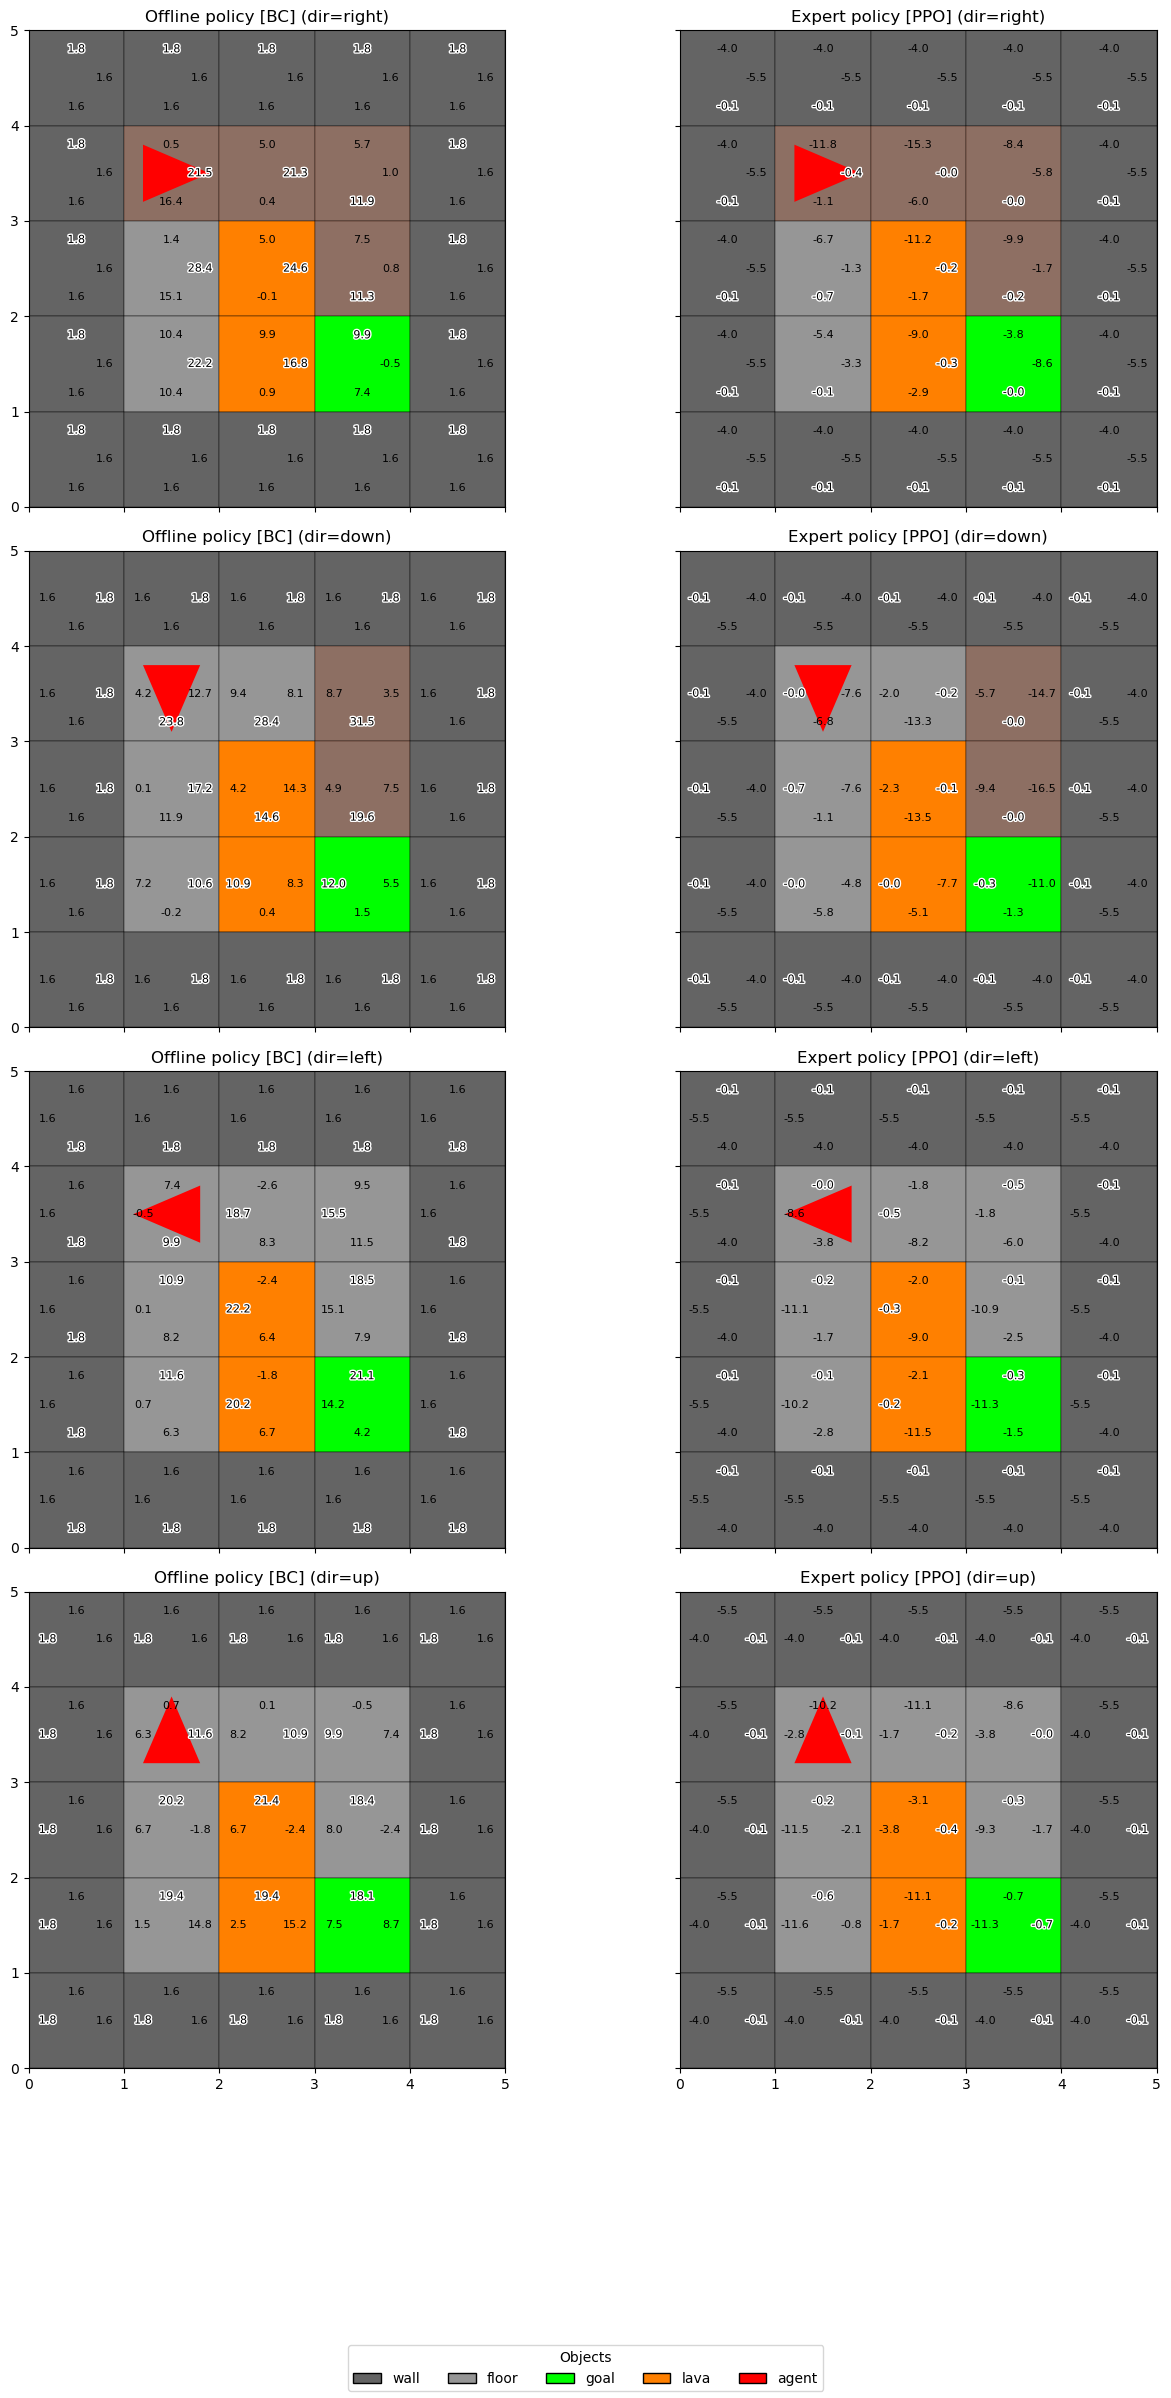

In [135]:
visualize_q_and_expert_visitation("bc")

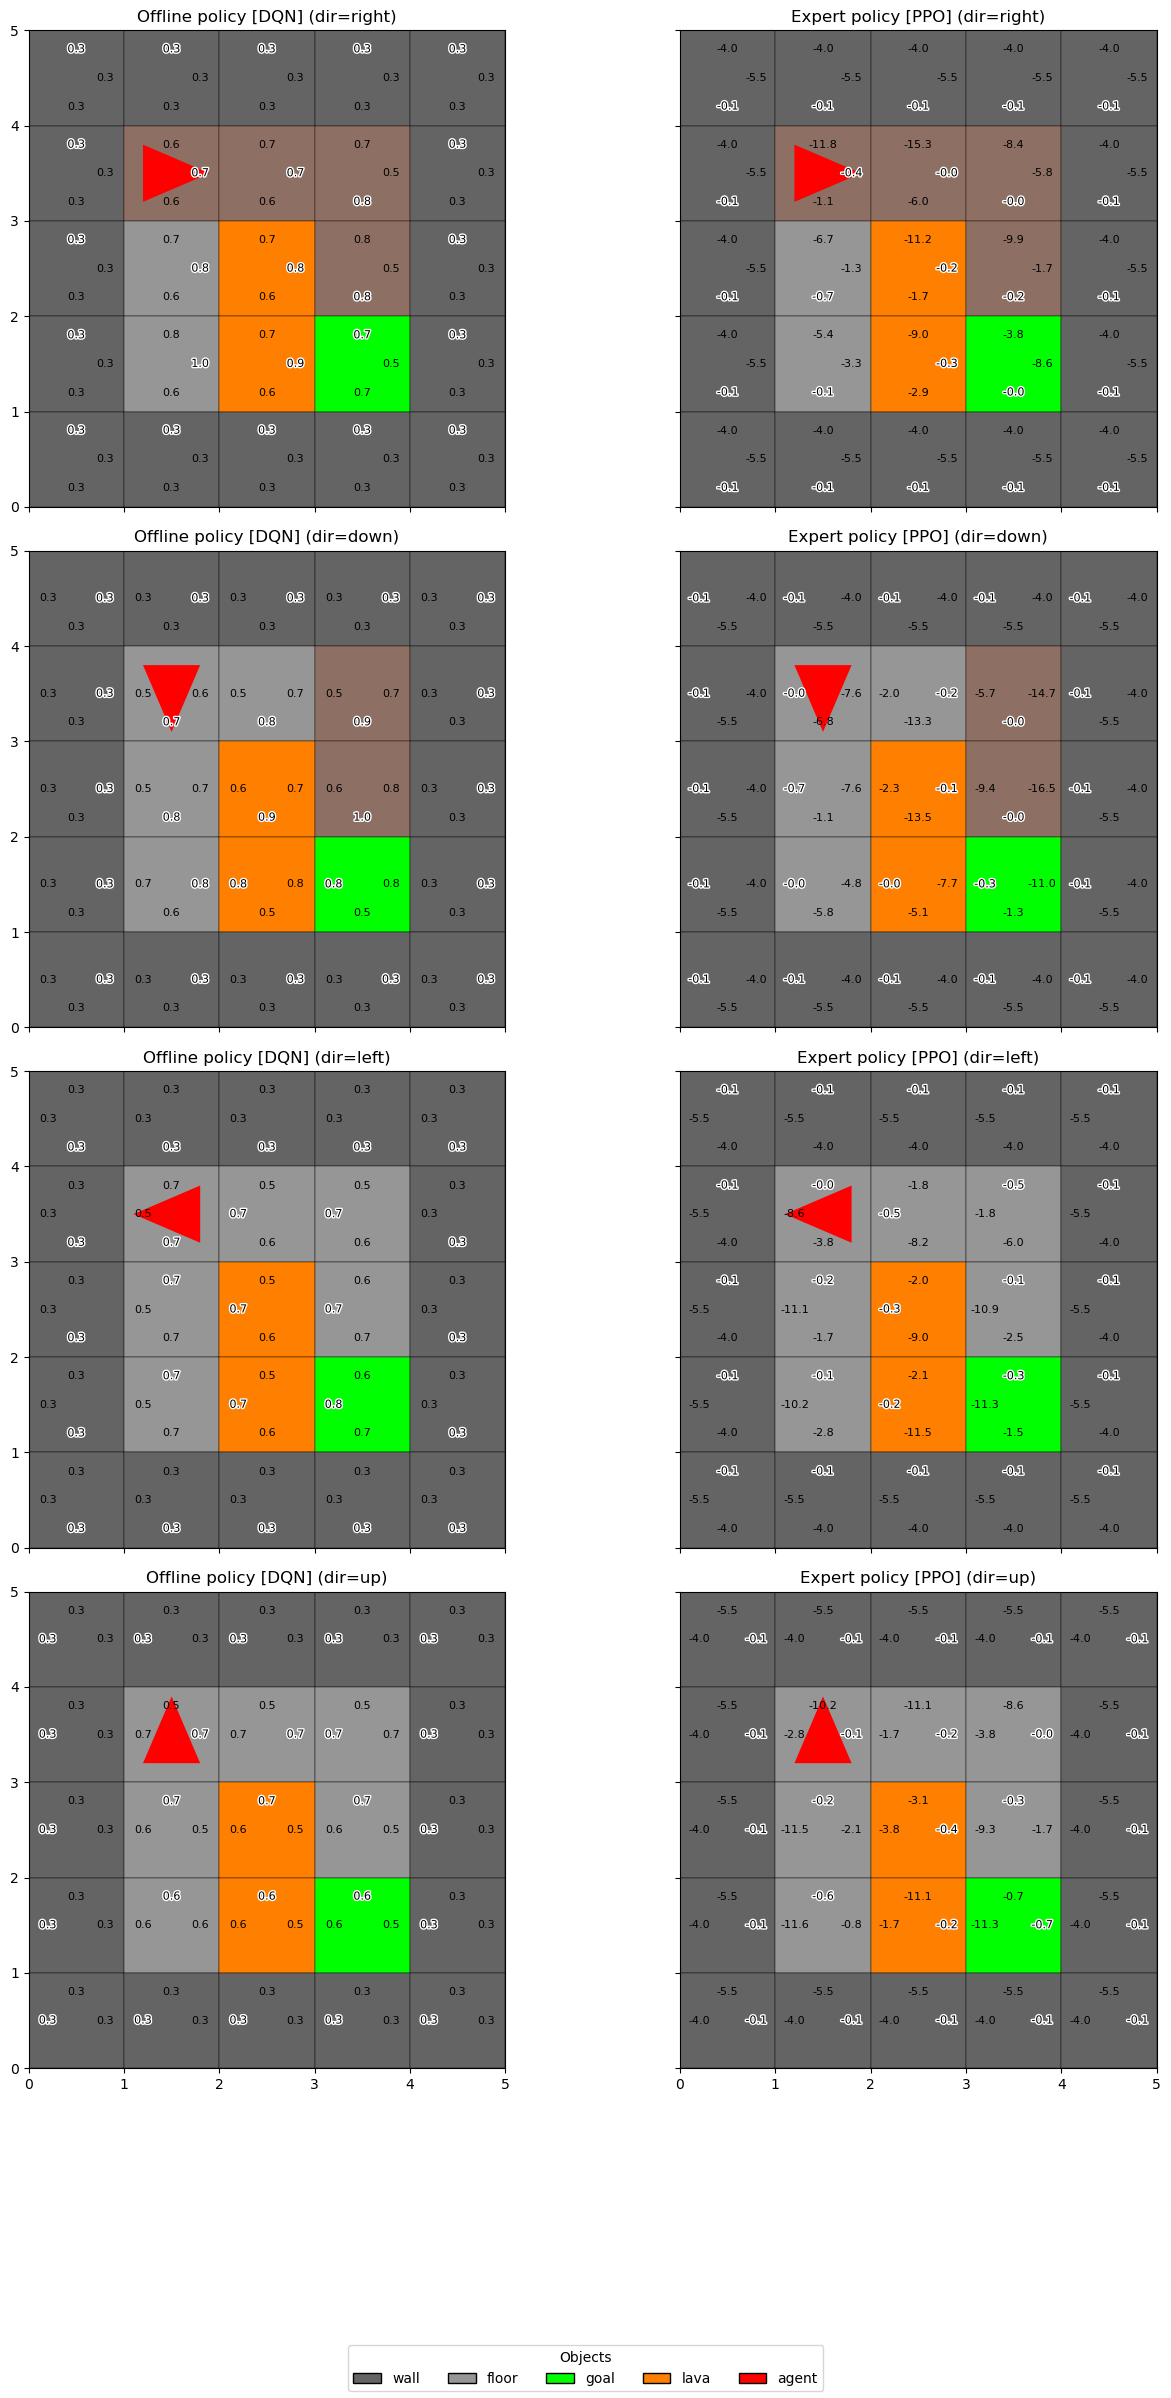

In [136]:
visualize_q_and_expert_visitation("dqn")

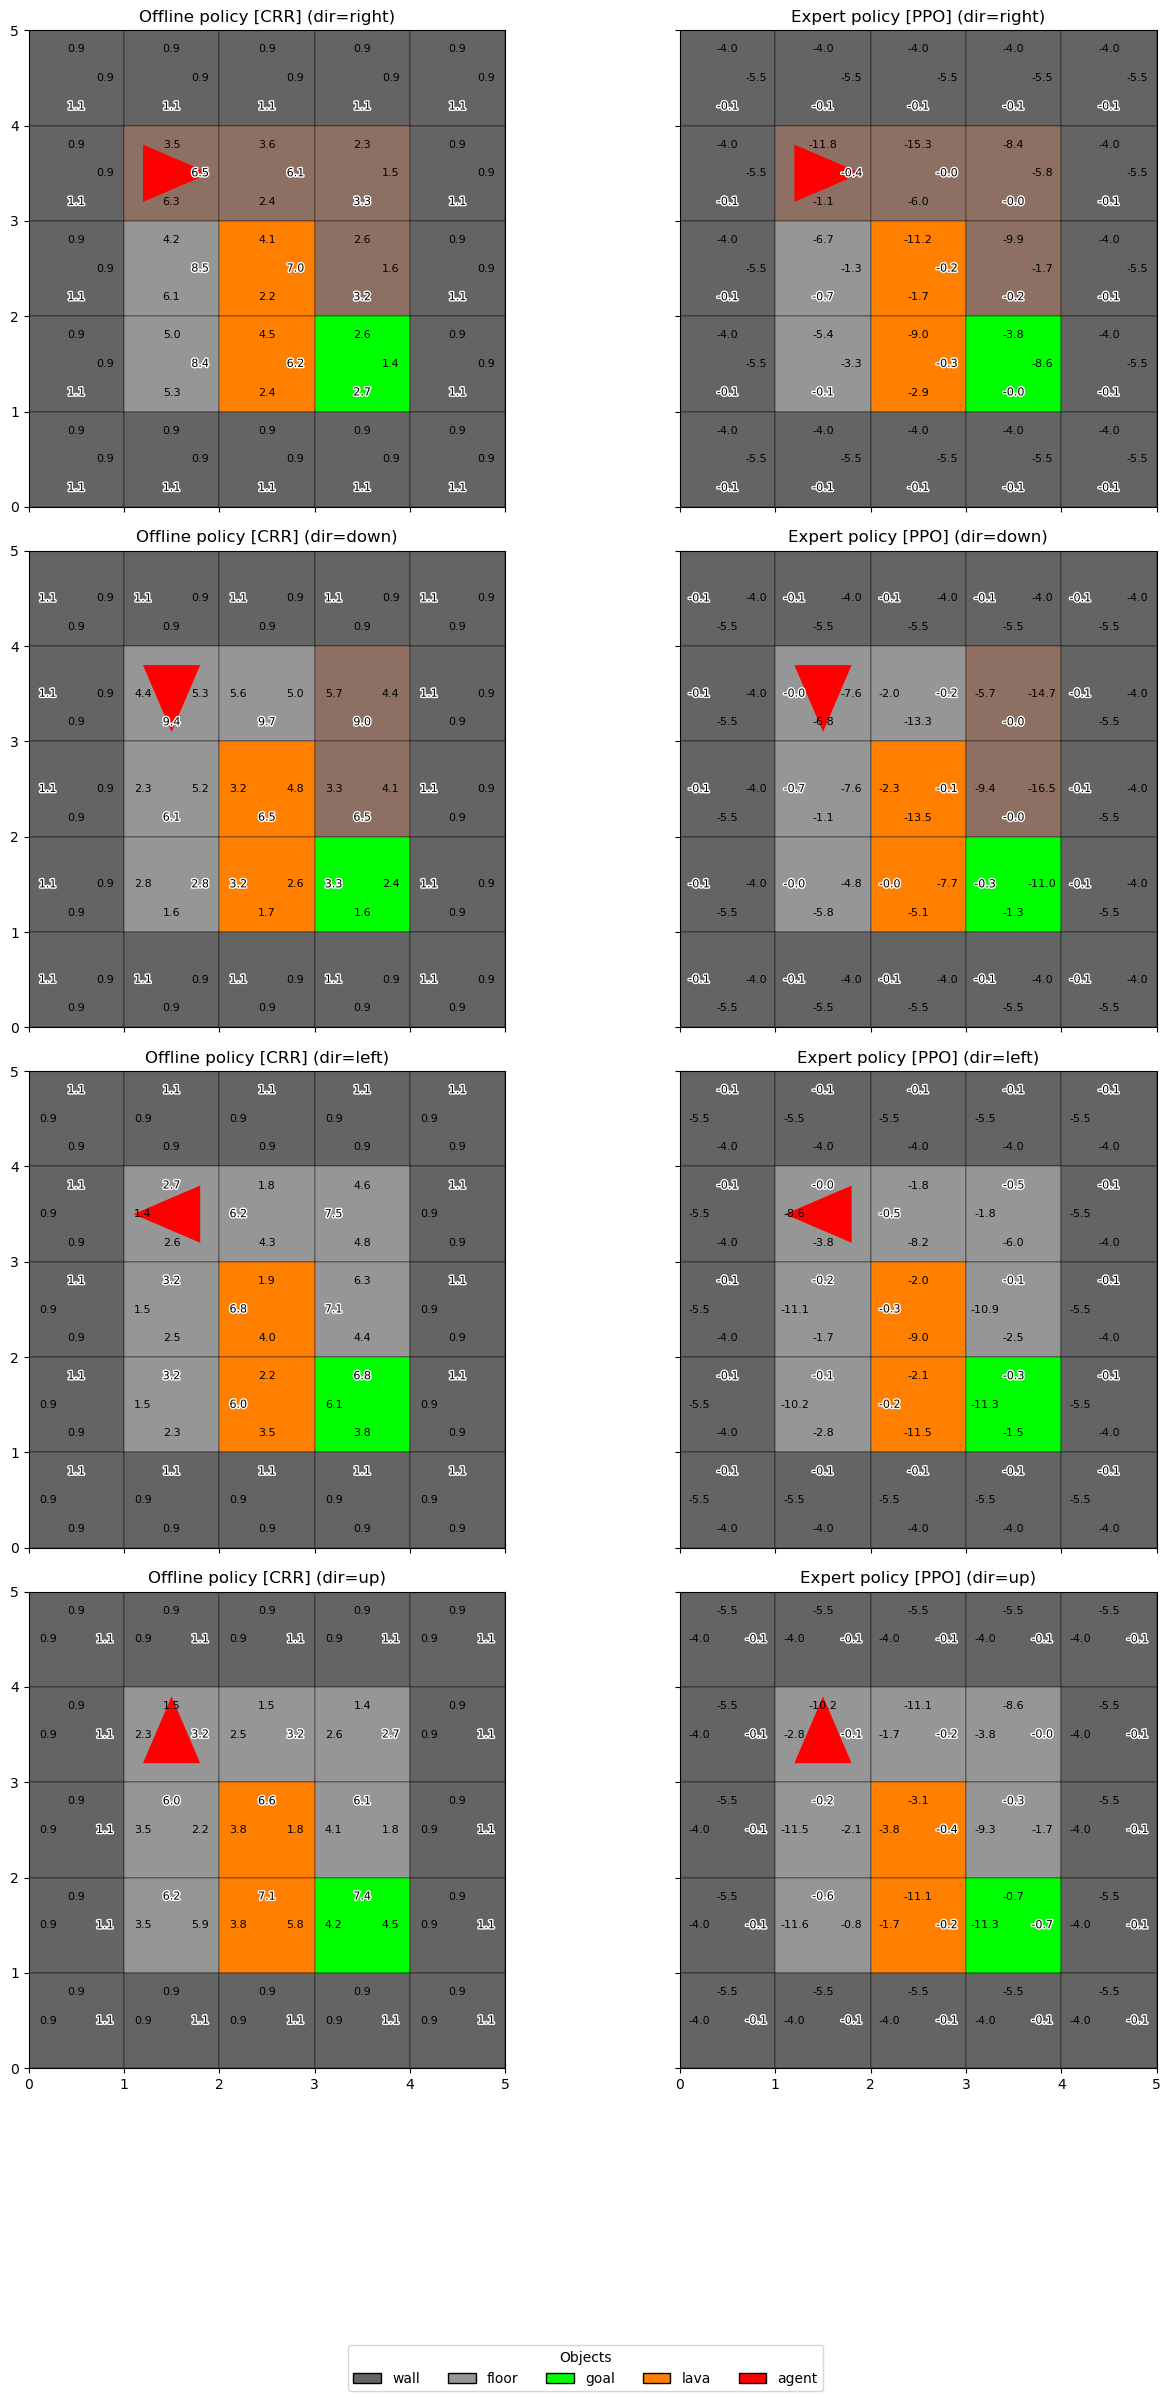

In [142]:
visualize_q_and_expert_visitation("crr")

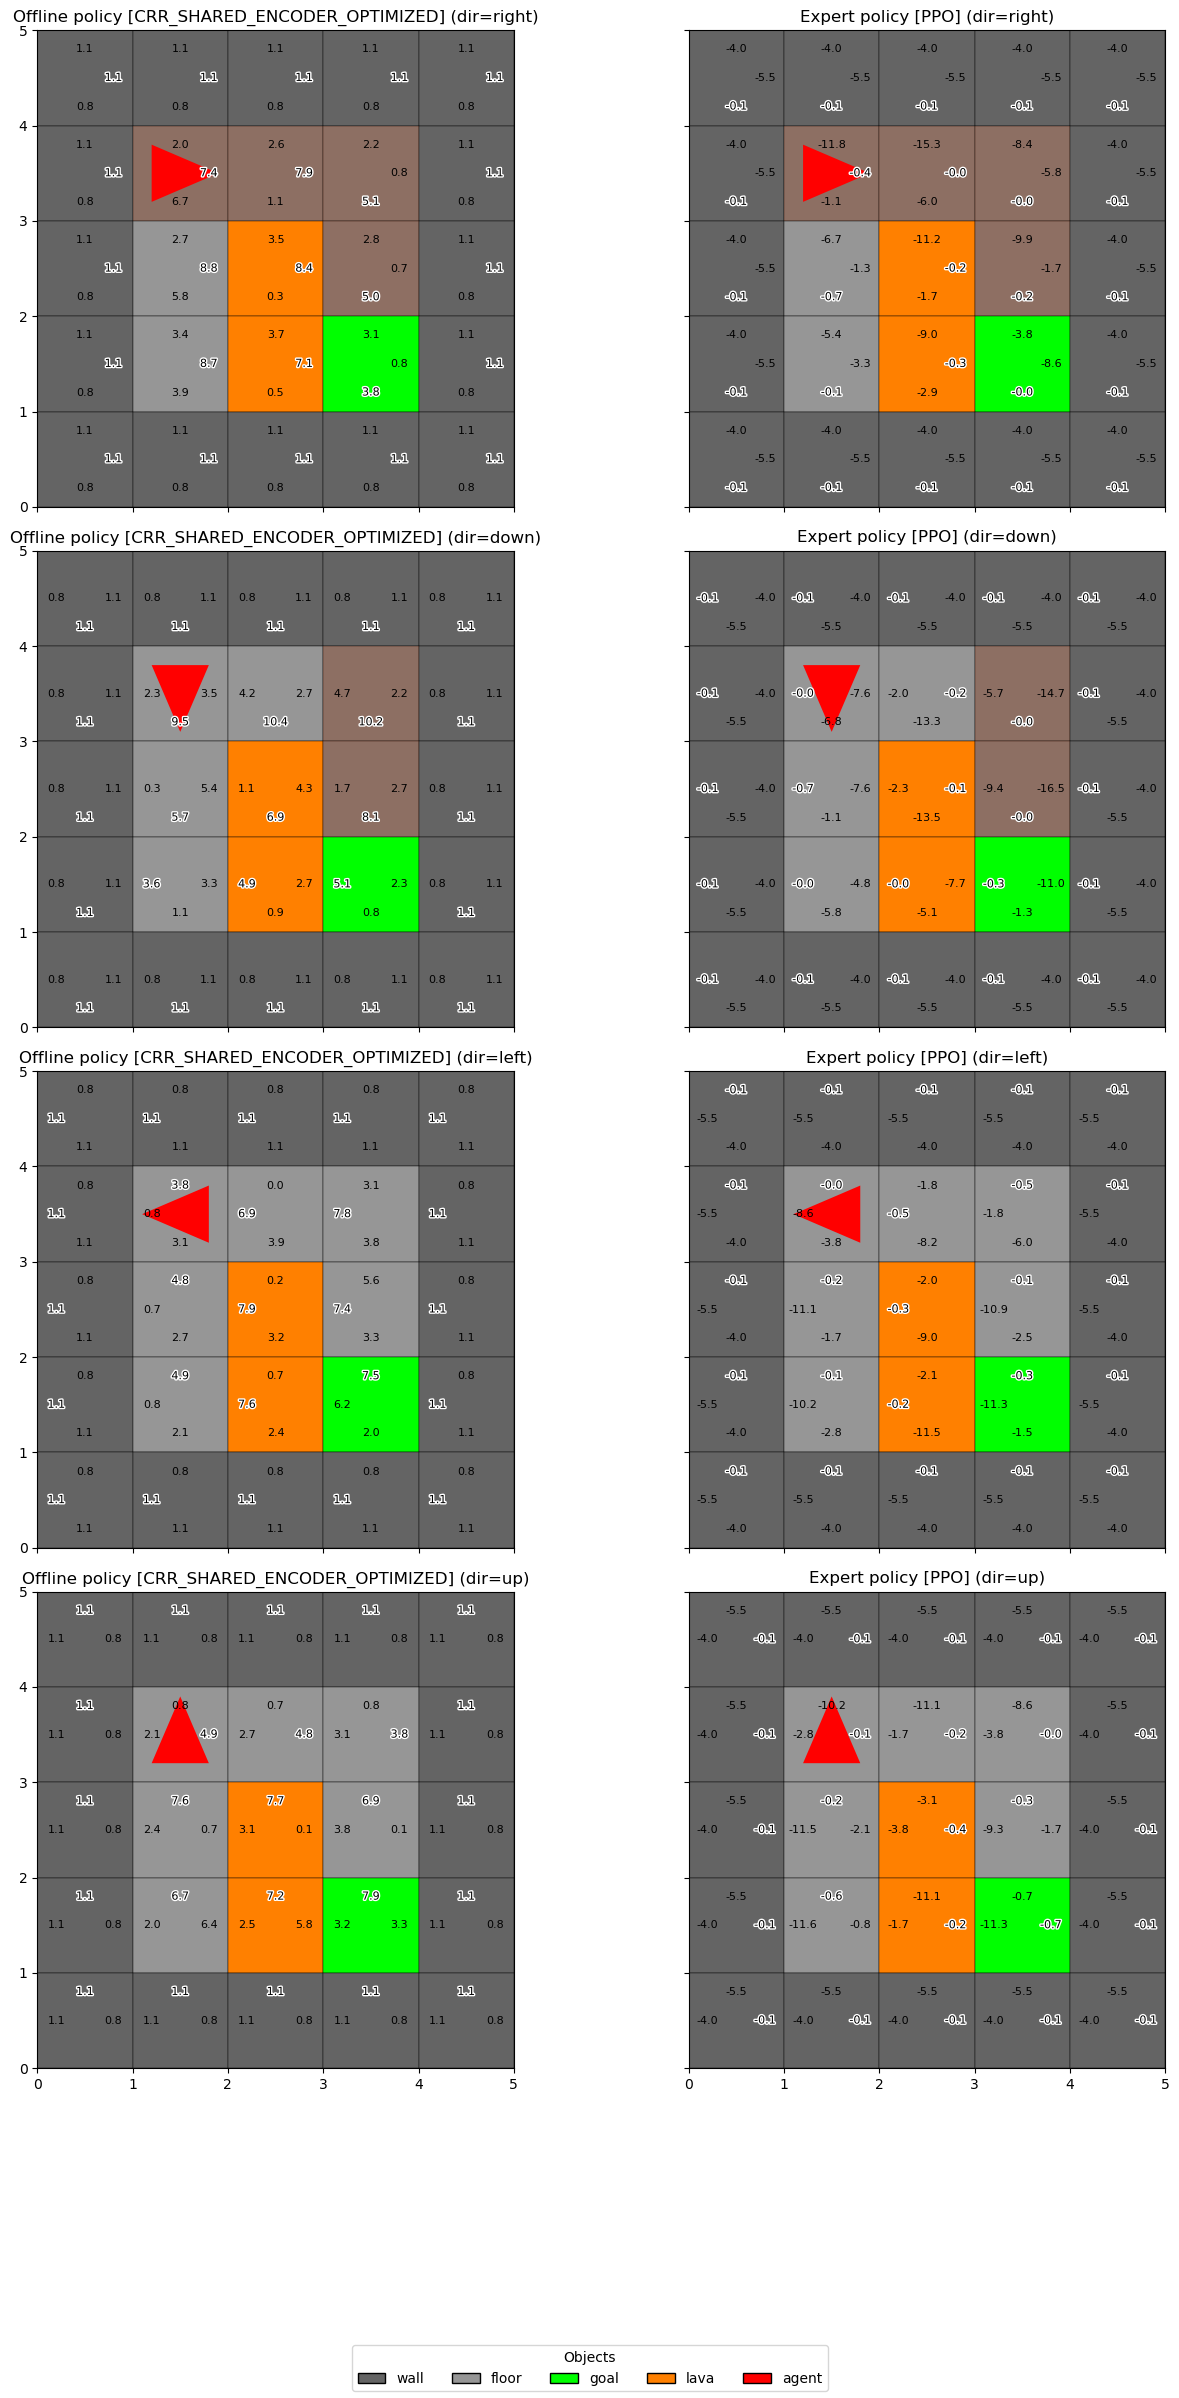

In [143]:
visualize_q_and_expert_visitation("crr_shared_encoder_optimized")